In [2]:
import pickle
import pandas as pd
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
import glob as glob
import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
from utils import calc_loadings
from collections import defaultdict
from scipy.stats import spearmanr
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import scipy.ndimage
import matplotlib.colors as mcolors

### Load consolidated dimreduc dataframe

In [3]:
path = '/home/marcush/Data/TsaoLabData/neural_control_output/degraded_dimreduc_param_search/degraded_dimreduc_param_search_glom.pickle'
with open(path, 'rb') as f:
    dat = pickle.load(f) 

df_dimreduc = pd.DataFrame(dat)

### Load CCA model

In [4]:
ccamodel_dir = df_dimreduc['results_file'][0]
CCA_dims = 25 #None

if CCA_dims == None:
    ccamodel_path = glob.glob(ccamodel_dir+"/CCA_*.pickle")[0]
else:
    ccamodel_path = os.path.dirname(ccamodel_dir)+f"/CCA_{CCA_dims}_dims.pickle"

with open(ccamodel_path, 'rb') as file:
    ccamodel = pickle.load(file)




/home/marcush/Data/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator CCA from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



### Some useful values

In [5]:
dimensions = np.unique(df_dimreduc['dim'])
n_folds = np.unique(df_dimreduc['fold_idx'])
regions = np.unique(df_dimreduc['loader_args'].apply(lambda x: x.get('region')))
dimreduc_methods = np.unique(df_dimreduc['dimreduc_method'])

In [6]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
importance_scores = recursive_defaultdict()



for reg in regions:
    if reg == 'ML':
        cca_proj = ccamodel.x_rotations_
    else:
        cca_proj = ccamodel.y_rotations_

    for dim in dimensions:

        importance_scores[reg]['CCA'][dim] = calc_loadings(cca_proj[:, 0:dim])
        
        for method in dimreduc_methods:    
            all_scores = np.zeros((len(n_folds), cca_proj.shape[0]))

            for n_fold in n_folds:

                coef = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == reg)  & 
                                            (df_dimreduc['dim'] == dim) & (df_dimreduc['fold_idx'] == n_fold) &
                                            (df_dimreduc['dimreduc_method'] == method)]['coef'].iloc[0]
                
                all_scores[n_fold, :] = calc_loadings(coef)

            importance_scores[reg][method][dim] = np.mean(all_scores, 0)



## Visualizing unit importance across subspaces

#### Area ML

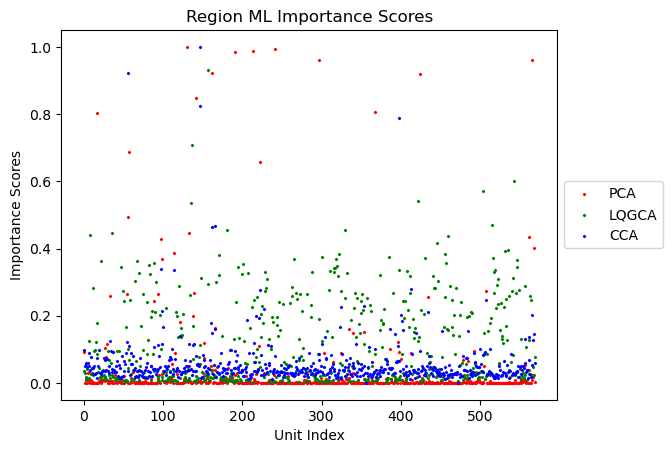

In [7]:
DIM = 21  

region = 'ML'

numUnits = ccamodel.x_rotations_.shape[0]  
xVals = np.arange(numUnits)

# Corrected scatter function usage
plt.scatter(xVals, importance_scores[region]['PCA'][DIM], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()


In [8]:
DIM = 21  
region = 'ML'


x = importance_scores[region]['PCA'][DIM]
y = importance_scores[region]['LQGCA'][DIM]
z = importance_scores[region]['CCA'][DIM]

init_notebook_mode(connected=True)
fig = go.Figure(data=[go.Scatter3d( x=x, y=y,  z=z,
                                    mode='markers', marker=dict( size=5, color='blue', opacity=0.8 ) )])

fig.update_layout( scene=dict( xaxis=dict(title='FFC'), yaxis=dict(title='FBC', autorange='reversed'),  zaxis=dict(title='CCA'),
                    camera=dict(eye=dict(x=1.25, y=1.25, z=1.25)) ), title=f'Region {region} importance scores', height=500 )


#fig.show()
#fig.write_html("ML_importance_scores.html")
#iplot(fig)


In [9]:
### CODE TO MAKE A MOVIE OF THE ABOVE PLOT
import imageio

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color='blue',    # static color
        opacity=0.8
    )
)])

# Add titles
fig.update_layout(
    scene=dict(
        xaxis_title='FFC',
        yaxis_title='FBC',
        zaxis_title='CCA'
    ),
    title='Interactive 3D Scatter Plot',
    height=700  # Set the height of the plot
)

# Function to capture frames at different angles
def capture_frames(fig, steps=36):
    frames = []
    for angle in np.linspace(0, 360, steps):
        fig.update_layout(scene_camera_eye=dict(x=np.sin(np.radians(angle)), y=np.cos(np.radians(angle)), z=0.5))
        img_bytes = fig.to_image(format="png")
        frames.append(imageio.imread(img_bytes))
    return frames

# Capture frames and create a video
#frames = capture_frames(fig)
#imageio.mimsave('3d_scatter_rotation.gif', frames, fps=10)

# To create a video file instead of a GIF, use the following line:
# imageio.mimsave('3d_scatter_rotation.mp4', frames, fps=10, codec='libx264')


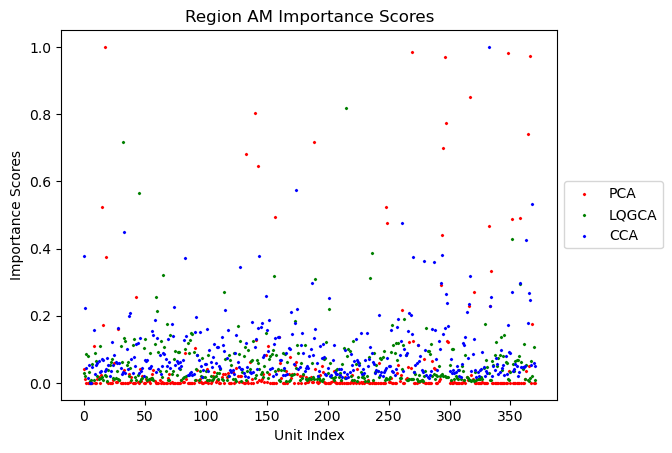

In [10]:
DIM = 21  
region = 'AM'

numUnits = ccamodel.y_rotations_.shape[0]  
xVals = np.arange(numUnits)

# Corrected scatter function usage
plt.scatter(xVals, importance_scores[region]['PCA'][DIM], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()


In [11]:
DIM = 21  
region = 'AM'


x = importance_scores[region]['PCA'][DIM]
y = importance_scores[region]['LQGCA'][DIM]
z = importance_scores[region]['CCA'][DIM]

init_notebook_mode(connected=True)
fig = go.Figure(data=[go.Scatter3d( x=x, y=y,  z=z,
                                    mode='markers', marker=dict( size=5, color='blue', opacity=0.8 ) )])

fig.update_layout( scene=dict( xaxis=dict(title='FFC'), yaxis=dict(title='FBC', autorange='reversed'),  zaxis=dict(title='CCA'),
                    camera=dict(eye=dict(x=1.25, y=1.25, z=1.25)) ), title=f'Region {region} importance scores', height=500 )


fig.show()
#iplot(fig)


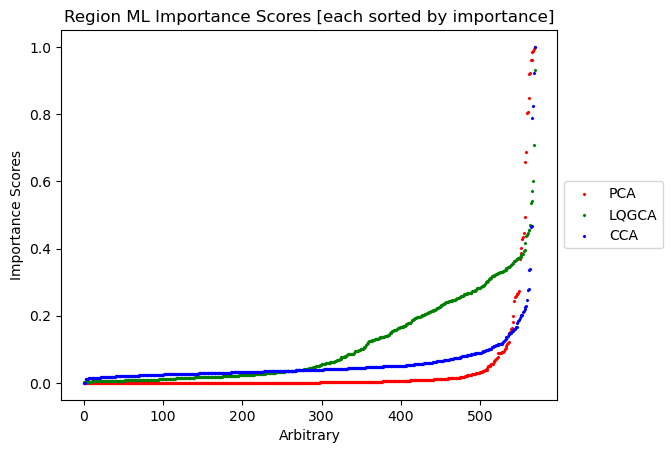

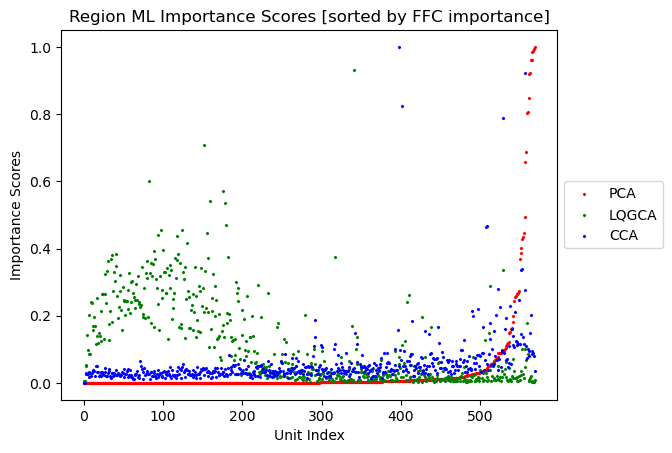

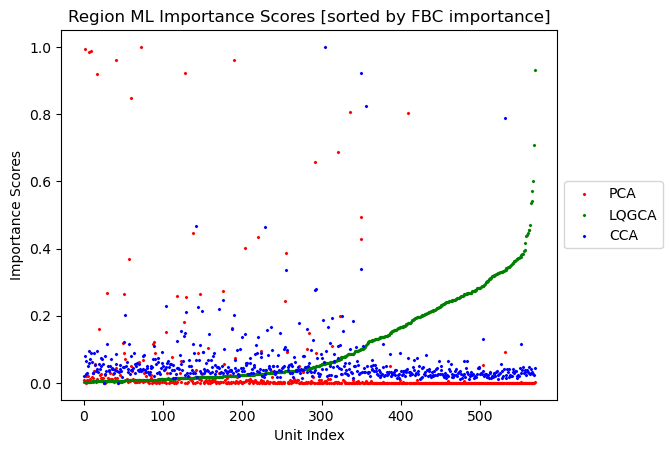

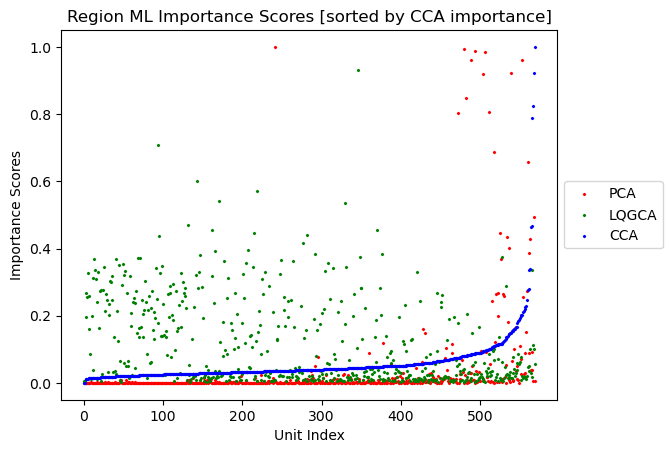

In [12]:
region = 'ML'
DIM = 21  

numUnits = ccamodel.x_rotations_.shape[0]  
xVals = np.arange(numUnits)

plt.scatter(xVals, np.sort(importance_scores[region]['PCA'][DIM]), marker='x', s=2, color='r')
plt.scatter(xVals, np.sort(importance_scores[region]['LQGCA'][DIM]), marker='x', s=2, color='g')
plt.scatter(xVals, np.sort(importance_scores[region]['CCA'][DIM]), marker='x', s=2, color='b')


plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [each sorted by importance]')
plt.xlabel('Arbitrary')  
plt.ylabel('Importance Scores')
plt.show()


inds = np.argsort(importance_scores[region]['PCA'][DIM])
#inds = np.argsort(importance_scores[region]['LQGCA'][DIM])
#inds = np.argsort(importance_scores[region]['CCA'][DIM])

plt.scatter(xVals, importance_scores[region]['PCA'][DIM][inds], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM][inds], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM][inds], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [sorted by FFC importance]')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()

#inds = np.argsort(importance_scores[region]['PCA'][DIM])
inds = np.argsort(importance_scores[region]['LQGCA'][DIM])
#inds = np.argsort(importance_scores[region]['CCA'][DIM])

plt.scatter(xVals, importance_scores[region]['PCA'][DIM][inds], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM][inds], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM][inds], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [sorted by FBC importance]')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()

#inds = np.argsort(importance_scores[region]['PCA'][DIM])
#inds = np.argsort(importance_scores[region]['LQGCA'][DIM])
inds = np.argsort(importance_scores[region]['CCA'][DIM])

plt.scatter(xVals, importance_scores[region]['PCA'][DIM][inds], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM][inds], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM][inds], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [sorted by CCA importance]')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()

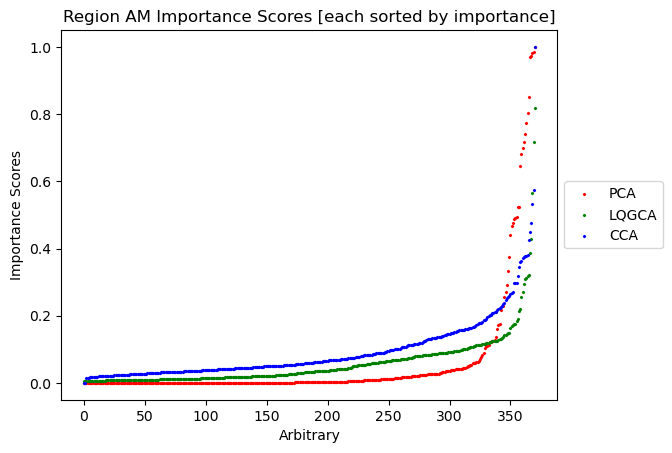

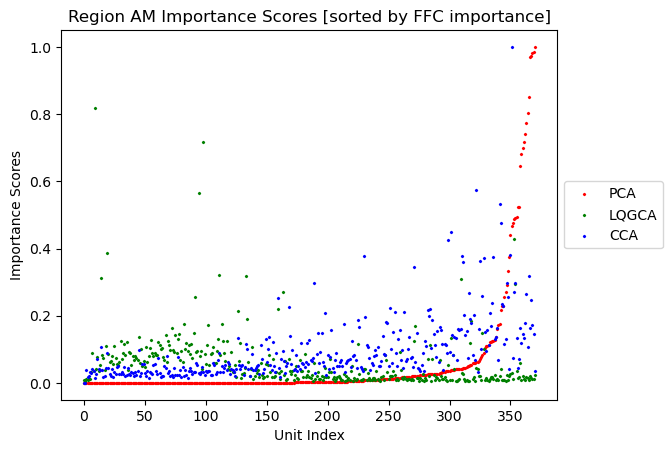

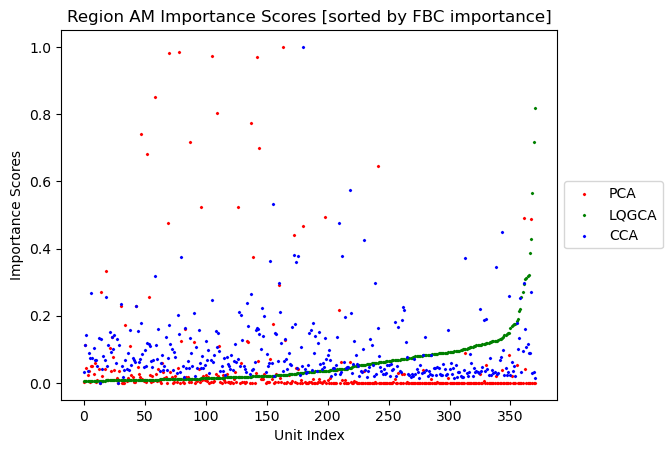

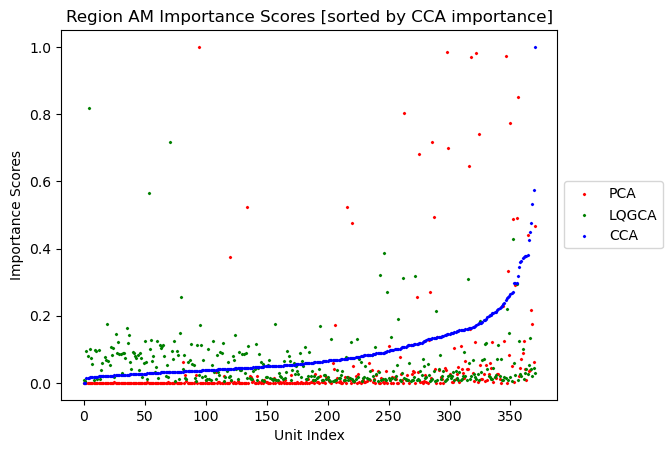

In [13]:
region = 'AM'
DIM = 21  


numUnits = ccamodel.y_rotations_.shape[0]  
xVals = np.arange(numUnits)

plt.scatter(xVals, np.sort(importance_scores[region]['PCA'][DIM]), marker='x', s=2, color='r')
plt.scatter(xVals, np.sort(importance_scores[region]['LQGCA'][DIM]), marker='x', s=2, color='g')
plt.scatter(xVals, np.sort(importance_scores[region]['CCA'][DIM]), marker='x', s=2, color='b')


plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [each sorted by importance]')
plt.xlabel('Arbitrary')  
plt.ylabel('Importance Scores')
plt.show()


inds = np.argsort(importance_scores[region]['PCA'][DIM])
#inds = np.argsort(importance_scores[region]['LQGCA'][DIM])
#inds = np.argsort(importance_scores[region]['CCA'][DIM])

plt.scatter(xVals, importance_scores[region]['PCA'][DIM][inds], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM][inds], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM][inds], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [sorted by FFC importance]')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()

#inds = np.argsort(importance_scores[region]['PCA'][DIM])
inds = np.argsort(importance_scores[region]['LQGCA'][DIM])
#inds = np.argsort(importance_scores[region]['CCA'][DIM])

plt.scatter(xVals, importance_scores[region]['PCA'][DIM][inds], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM][inds], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM][inds], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [sorted by FBC importance]')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()


#inds = np.argsort(importance_scores[region]['PCA'][DIM])
#inds = np.argsort(importance_scores[region]['LQGCA'][DIM])
inds = np.argsort(importance_scores[region]['CCA'][DIM])

plt.scatter(xVals, importance_scores[region]['PCA'][DIM][inds], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM][inds], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM][inds], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [sorted by CCA importance]')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()

In [14]:
ML_FFC_sum = np.sum(importance_scores['ML']['PCA'][np.max(dimensions)])
ML_FBC_sum = np.sum(importance_scores['ML']['LQGCA'][np.max(dimensions)])
ML_CCA_sum = np.sum(importance_scores['ML']['CCA'][np.max(dimensions)])

AM_FFC_sum = np.sum(importance_scores['AM']['PCA'][np.max(dimensions)])
AM_FBC_sum = np.sum(importance_scores['AM']['LQGCA'][np.max(dimensions)])
AM_CCA_sum = np.sum(importance_scores['AM']['CCA'][np.max(dimensions)])


print(f"ML FFC total importance: {ML_FFC_sum}")
print(f"ML FBC total importance: {ML_FBC_sum}")
print(f"ML CCA total importance: {ML_CCA_sum}")
print()
print(f"AM FFC total importance: {AM_FFC_sum}")
print(f"AM FBC total importance: {AM_FBC_sum}")
print(f"AM CCA total importance: {AM_CCA_sum}")



ML FFC total importance: 69.44095562838982
ML FBC total importance: 75.60419521466679
ML CCA total importance: 31.277706246066714

AM FFC total importance: 69.47733026727295
AM FBC total importance: 69.558385744612
AM CCA total importance: 38.84048806289004


In [15]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
subspace_importance_correlations = recursive_defaultdict()
subspace_importance_pvals = recursive_defaultdict()

proj_methods = np.append(dimreduc_methods, 'CCA')

for region in regions:
    region_method_pairs = set()  # Set to keep track of seen combinations
    if region == 'AM':
        DIM = 21 #39
    elif region == 'ML':
        DIM = 21

    for method0, method1 in itertools.product(proj_methods, proj_methods):
        sorted_0 = tuple(sorted([region, method0]))
        sorted_1 = tuple(sorted([region, method1]))
        
        combo = (tuple(sorted((sorted_0, sorted_1))))
        
        if combo in region_method_pairs:
            continue  
        elif method0 == method1:
            continue
        region_method_pairs.add(combo)



        scores0 = importance_scores[region][method0][DIM]
        scores1 = importance_scores[region][method1][DIM]

        corrs, pvals = spearmanr(scores0, scores1 ) 

        subspace_importance_correlations[region][f"{method0}_{method1}"] = corrs
        subspace_importance_pvals[region][f"{method0}_{method1}"] = pvals


In [16]:
AM_corrs = np.array(list(subspace_importance_correlations['AM'].values()))
ML_corrs = np.array(list(subspace_importance_correlations['ML'].values()))
comparisons = np.array(list(subspace_importance_correlations['AM'].keys()))

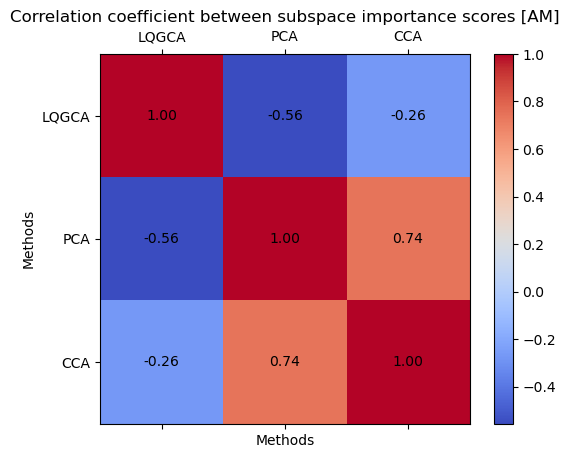

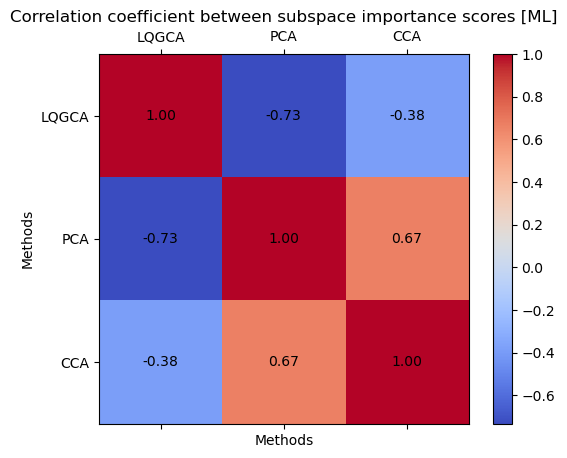

In [17]:
methods = proj_methods
indices = {name: i for i, name in enumerate(proj_methods)}

# Function to create a heatmap from correlations
def create_heatmap(corrs, comparisons, methods, region):
    # Initialize a 3x3 matrix of NaNs
    matrix = np.full((3, 3), np.nan)
    
    # Fill the matrix with correlations
    for comp, corr in zip(comparisons, corrs):
        m1, m2 = comp.split('_')
        i, j = indices[m1], indices[m2]
        matrix[i, j] = corr
        matrix[j, i] = corr  # Mirror the value
    
    # Diagonal (comparison of the method with itself)
    for i in range(3):
        matrix[i, i] = 1.0  # Perfect correlation with itself
    
    # Plotting
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap='coolwarm')
    plt.colorbar(cax)
    ax.set_xticks(range(len(methods)))
    ax.set_yticks(range(len(methods)))
    ax.set_xticklabels(methods)
    ax.set_yticklabels(methods)

    for (i, j), val in np.ndenumerate(matrix):
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='black')

    plt.title(f'Correlation coefficient between subspace importance scores [{region}]')
    plt.xlabel('Methods')
    plt.ylabel('Methods')
    plt.show()

create_heatmap(AM_corrs, comparisons, proj_methods, 'AM')
create_heatmap(ML_corrs, comparisons, proj_methods, 'ML')


# Figs from paper

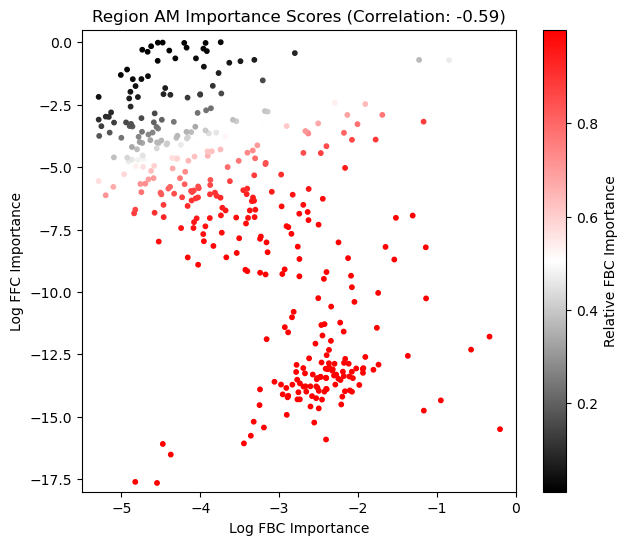

In [18]:
region = 'AM'
DIM = 21  


FFC_scores = importance_scores[region]['PCA'][DIM]
FBC_scores = importance_scores[region]['LQGCA'][DIM]

rel_FBC_import = FBC_scores / (FBC_scores + FFC_scores)

sort_inds = np.argsort(FFC_scores)

FBC_scores_plt = np.log(FBC_scores[sort_inds[2:]])
FFC_scores_plt = np.log(FFC_scores[sort_inds[2:]])
rel_FBC_import_plt = rel_FBC_import[sort_inds[2:]]

cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])

plt.figure(figsize=(7, 6))
scatter = plt.scatter(FBC_scores_plt, FFC_scores_plt, c=rel_FBC_import_plt, cmap=cmap, marker='o', s=10)
colorbar = plt.colorbar(scatter)
colorbar.set_label('Relative FBC Importance')

plt.title(f'Region {region} Importance Scores (Correlation: {np.corrcoef(FBC_scores_plt, FFC_scores_plt)[0, 1]:.2f})')
plt.xlabel('Log FBC Importance')
plt.ylabel('Log FFC Importance')
plt.xlim(-5.5, 0)
plt.ylim(-18, 0.5)
plt.show()

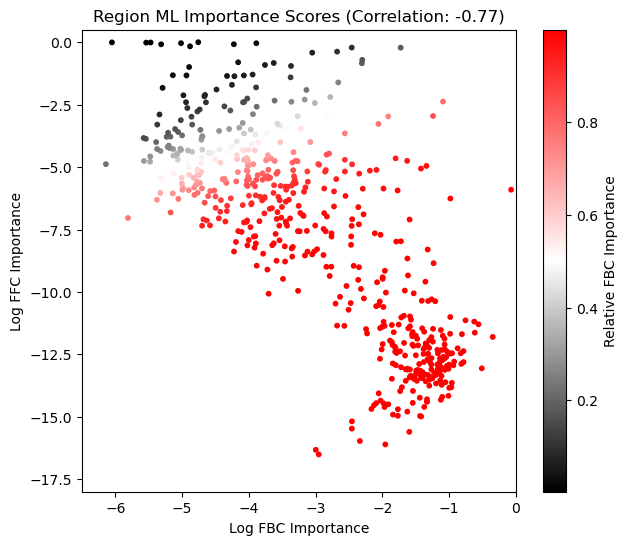

In [19]:
region = 'ML'
DIM = 21  


FFC_scores = importance_scores[region]['PCA'][DIM]
FBC_scores = importance_scores[region]['LQGCA'][DIM]

rel_FBC_import = FBC_scores / (FBC_scores + FFC_scores)

sort_inds = np.argsort(FFC_scores)

FBC_scores_plt = np.log(FBC_scores[sort_inds[2:]])
FFC_scores_plt = np.log(FFC_scores[sort_inds[2:]])
rel_FBC_import_plt = rel_FBC_import[sort_inds[2:]]

cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])

plt.figure(figsize=(7, 6))
scatter = plt.scatter(FBC_scores_plt, FFC_scores_plt, c=rel_FBC_import_plt, cmap=cmap, marker='o', s=10)
colorbar = plt.colorbar(scatter)
colorbar.set_label('Relative FBC Importance')

plt.title(f'Region {region} Importance Scores (Correlation: {np.corrcoef(FBC_scores_plt, FFC_scores_plt)[0, 1]:.2f})')
plt.xlabel('Log FBC Importance')
plt.ylabel('Log FFC Importance')
plt.xlim(-6.5, 0)
plt.ylim(-18, 0.5)
plt.show()

In [20]:
def make_hashable(d):
    return tuple(sorted((key, make_hashable(value)) if isinstance(value, dict) else (key, value)
                        for key, value in d.items()))


unique_hashes = set(make_hashable(d) for d in df_dimreduc['loader_args'])
unique_dicts = [dict(u) for u in unique_hashes]

for u in unique_dicts:
    u['data_path'] = df_dimreduc['data_path'][0] + "/" + df_dimreduc['data_file'][0]
    u['spike_threshold'] = None
    u['trial_threshold'] = None

In [21]:
preload_dict_path = df_dimreduc['data_path'][0] + "/preloaded/preloadDict.pickle"

with open(preload_dict_path, 'rb') as file:
    preloadDict = pickle.load(file)


for arg_dict in unique_dicts:
    arg_tuple = tuple(sorted(arg_dict.items()))


    for args in preloadDict.keys():

        if args == arg_tuple:

            preloadID = preloadDict[arg_tuple]
            loaded_data_path = os.path.dirname(preload_dict_path) + f"/preloaded_data_{preloadID}.pickle"
            
            if arg_dict['region'] == 'AM':
                with open(loaded_data_path, 'rb') as file:
                    AM_loaded_data = pickle.load(file)

            elif arg_dict['region'] == 'ML':
                with open(loaded_data_path, 'rb') as file:
                    ML_loaded_data = pickle.load(file)

AM_spikes = np.sum(AM_loaded_data['spike_rates'], 1)
ML_spikes = np.sum(ML_loaded_data['spike_rates'], 1)

In [22]:
np.shape(AM_loaded_data['spike_rates'])

(1991, 39, 371)

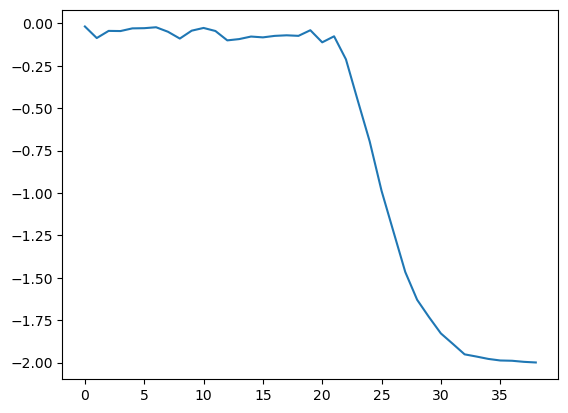

In [23]:
AM_rates = AM_loaded_data['spike_rates']

AM_avg_rates = np.mean(AM_rates, 0)

sortInds = np.argsort(np.sum(AM_avg_rates, 0))


plt.plot(AM_avg_rates[:,sortInds[-1]])

### Rebuild the spike rate structure

In [24]:
AM_loaded_data.keys()

dict_keys(['ParadigmName', 'probeID', 'channelID', 'waveforms', 'waveforms_time', 'Regions', 'regionIDs', 'NumUnits', 'NumTrials', 'TrialStartTimes', 'StimulusOnDurations', 'StimulusOFFDurations', 'StimulusNames', 'StimIDs', 'behavior', 'TrialDurations', 'bin_width', 'SessionName', 'spike_times', 'spike_rates', 'stratifiedIDs', 'degradedIDs'])

Median stimulus on time: 515.0ms


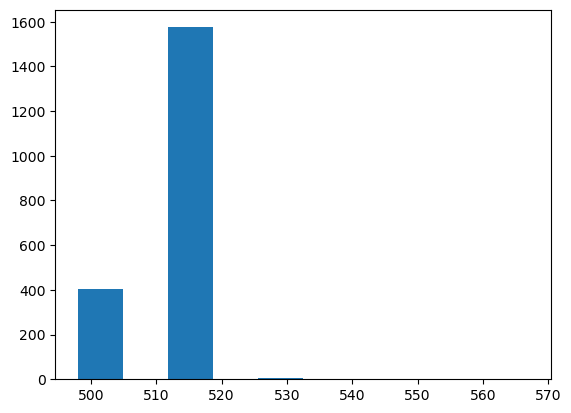

In [25]:
plt.hist(AM_loaded_data['StimulusOnDurations'])
print(f"Median stimulus on time: {np.median(AM_loaded_data['StimulusOnDurations'])}ms")
median_stim_on_time = np.median(AM_loaded_data['StimulusOnDurations'])

In [26]:
bin_width = AM_loaded_data['bin_width']
num_bins = np.shape(AM_loaded_data['spike_rates'])[1]
trial_dur = num_bins * bin_width
num_units = np.shape(AM_loaded_data['spike_times'])[1]
num_trials = np.shape(AM_loaded_data['spike_times'])[0]

AM_spike_times = AM_loaded_data['spike_times']
all_rates_AM = np.zeros((num_units, trial_dur))

for unit in np.arange(num_units):
    trials_mat = np.zeros((num_trials, trial_dur))

    for trial in np.arange(num_trials):

        sp_times = AM_spike_times[trial][unit][0]
        sp_times = sp_times[sp_times < trial_dur]
        trials_mat[trial, sp_times] = 1

    
    all_rates_AM[unit, :] = np.mean(trials_mat, 0)
        

In [27]:
bin_width = ML_loaded_data['bin_width']
num_bins = np.shape(ML_loaded_data['spike_rates'])[1]
trial_dur = num_bins * bin_width
num_units = np.shape(ML_loaded_data['spike_times'])[1]
num_trials = np.shape(ML_loaded_data['spike_times'])[0]


ML_spike_times = ML_loaded_data['spike_times']
all_rates_ML = np.zeros((num_units, trial_dur))

for unit in np.arange(num_units):
    trials_mat = np.zeros((num_trials, trial_dur))

    for trial in np.arange(num_trials):

        sp_times = ML_spike_times[trial][unit][0]
        sp_times = sp_times[sp_times < trial_dur]
        trials_mat[trial, sp_times] = 1

    
    all_rates_ML[unit, :] = np.mean(trials_mat, 0)
        

In [28]:
kernel_size = 50  # ms

bin_width = ML_loaded_data['bin_width']
num_bins = np.shape(ML_loaded_data['spike_rates'])[1]
trial_dur = num_bins * bin_width
num_units = np.shape(ML_loaded_data['spike_times'])[1]
num_trials = np.shape(ML_loaded_data['spike_times'])[0]

ML_spike_times = ML_loaded_data['spike_times']
zsmooth_rates_ML = np.zeros((num_units, trial_dur))

for unit in np.arange(num_units):
    trials_mat = np.zeros((num_trials, trial_dur))

    for trial in np.arange(num_trials):

        sp_times = ML_spike_times[trial][unit][0]
        sp_times = sp_times[sp_times < trial_dur]
        temp_raster = np.zeros(trial_dur)
        temp_raster[sp_times] = 1
        smoothed_raster = scipy.ndimage.gaussian_filter1d(temp_raster, sigma = kernel_size / np.sqrt(8 * np.log(2)))
        trials_mat[trial, :] = smoothed_raster

    mean_resp = np.mean(trials_mat, 0)
    zsmooth_rates_ML[unit, :] = scipy.stats.zscore(mean_resp)
        

In [29]:
kernel_size = 50  # ms

bin_width = AM_loaded_data['bin_width']
num_bins = np.shape(AM_loaded_data['spike_rates'])[1]
trial_dur = num_bins * bin_width
num_units = np.shape(AM_loaded_data['spike_times'])[1]
num_trials = np.shape(AM_loaded_data['spike_times'])[0]

AM_spike_times = AM_loaded_data['spike_times']
zsmooth_rates_AM = np.zeros((num_units, trial_dur))

for unit in np.arange(num_units):
    trials_mat = np.zeros((num_trials, trial_dur))

    for trial in np.arange(num_trials):

        sp_times = AM_spike_times[trial][unit][0]
        sp_times = sp_times[sp_times < trial_dur]
        temp_raster = np.zeros(trial_dur)
        temp_raster[sp_times] = 1
        smoothed_raster = scipy.ndimage.gaussian_filter1d(temp_raster, sigma = kernel_size / np.sqrt(8 * np.log(2)))
        trials_mat[trial, :] = smoothed_raster

    mean_resp = np.mean(trials_mat, 0)
    zsmooth_rates_AM[unit, :] = scipy.stats.zscore(mean_resp)
        

In [30]:
import scipy.ndimage

def smooth_array_with_gaussian(array, kernel_width=25):

    kernel_size = 25  # ms
    smoothed_array = scipy.ndimage.gaussian_filter1d(array, sigma = kernel_size / np.sqrt(8 * np.log(2)))
    return smoothed_array

Text(0.5, 1.0, 'All Avg Firing Rates in ML')

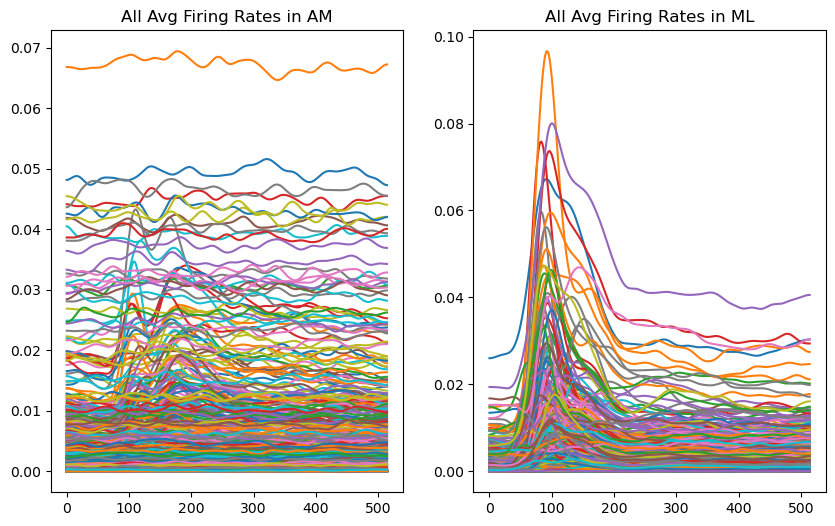

In [31]:
smoothed_AM = np.apply_along_axis(smooth_array_with_gaussian, 1, all_rates_AM[:, 0:int(median_stim_on_time)], kernel_width=25)
smoothed_ML = np.apply_along_axis(smooth_array_with_gaussian, 1, all_rates_ML[:, 0:int(median_stim_on_time)], kernel_width=25)

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(smoothed_AM.T);
plt.title("All Avg Firing Rates in AM")

plt.subplot(1,2,2)
plt.plot(smoothed_ML.T);
plt.title("All Avg Firing Rates in ML")


Text(0.5, 1.0, 'Trial averaged, Z-scored firing Rates in ML')

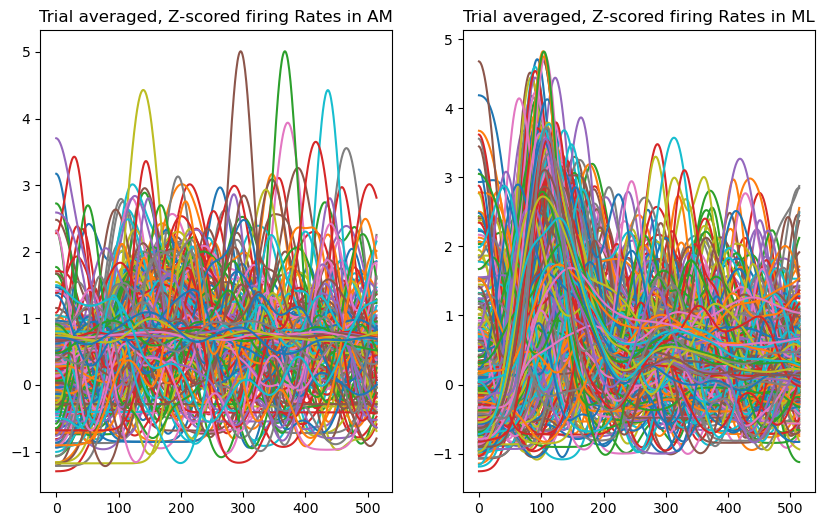

In [32]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(zsmooth_rates_AM[:, 0:int(median_stim_on_time)].T);
plt.title("Trial averaged, Z-scored firing Rates in AM")
plt.subplot(1,2,2)
plt.plot(zsmooth_rates_ML[:, 0:int(median_stim_on_time)].T);
plt.title("Trial averaged, Z-scored firing Rates in ML")

## Firing Rate profiles by importance

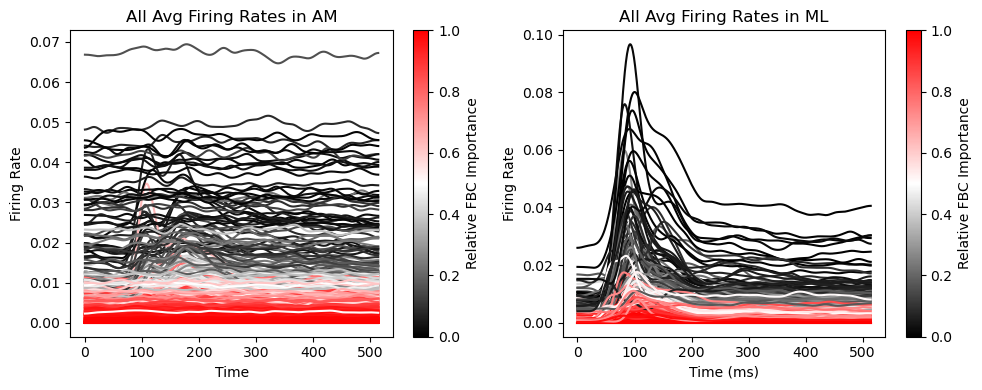

In [33]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

# Define the smoothing function
def smooth_array_with_gaussian(array, kernel_width=25):
    sigma = kernel_width / np.sqrt(8 * np.log(2))  # Convert kernel width to standard deviation
    smoothed_array = scipy.ndimage.gaussian_filter1d(array, sigma=sigma)
    return smoothed_array

# Assuming importance_scores, all_rates_AM, all_rates_ML, and median_stim_on_time are already defined
ffc_scores_am = importance_scores['AM']['PCA'][DIM]
fbc_scores_am = importance_scores['AM']['LQGCA'][DIM]
rel_FBC_import_am = fbc_scores_am / (fbc_scores_am + ffc_scores_am)

ffc_scores_ml = importance_scores['ML']['PCA'][DIM]
fbc_scores_ml = importance_scores['ML']['LQGCA'][DIM]
rel_FBC_import_ml = fbc_scores_ml / (fbc_scores_ml + ffc_scores_ml)

# Smooth firing rates
smoothed_AM = np.apply_along_axis(smooth_array_with_gaussian, 1, all_rates_AM[:, 0:int(median_stim_on_time)], kernel_width=25)
smoothed_ML = np.apply_along_axis(smooth_array_with_gaussian, 1, all_rates_ML[:, 0:int(median_stim_on_time)], kernel_width=25)

# Create a colormap
cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])

# Create the subplot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot for AM region
for i in range(smoothed_AM.shape[0]):
    axes[0].plot(smoothed_AM[i], color=cmap(rel_FBC_import_am[i]))
axes[0].set_title("All Avg Firing Rates in AM")
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Firing Rate')

# Plot for ML region
for i in range(smoothed_ML.shape[0]):
    axes[1].plot(smoothed_ML[i], color=cmap(rel_FBC_import_ml[i]))
axes[1].set_title("All Avg Firing Rates in ML")
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Firing Rate')

# Add colorbars
sm_am = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
sm_am.set_array([])
cbar_am = fig.colorbar(sm_am, ax=axes[0], orientation='vertical')
cbar_am.set_label('Relative FBC Importance')

sm_ml = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
sm_ml.set_array([])
cbar_ml = fig.colorbar(sm_ml, ax=axes[1], orientation='vertical')
cbar_ml.set_label('Relative FBC Importance')

plt.tight_layout()
plt.show()


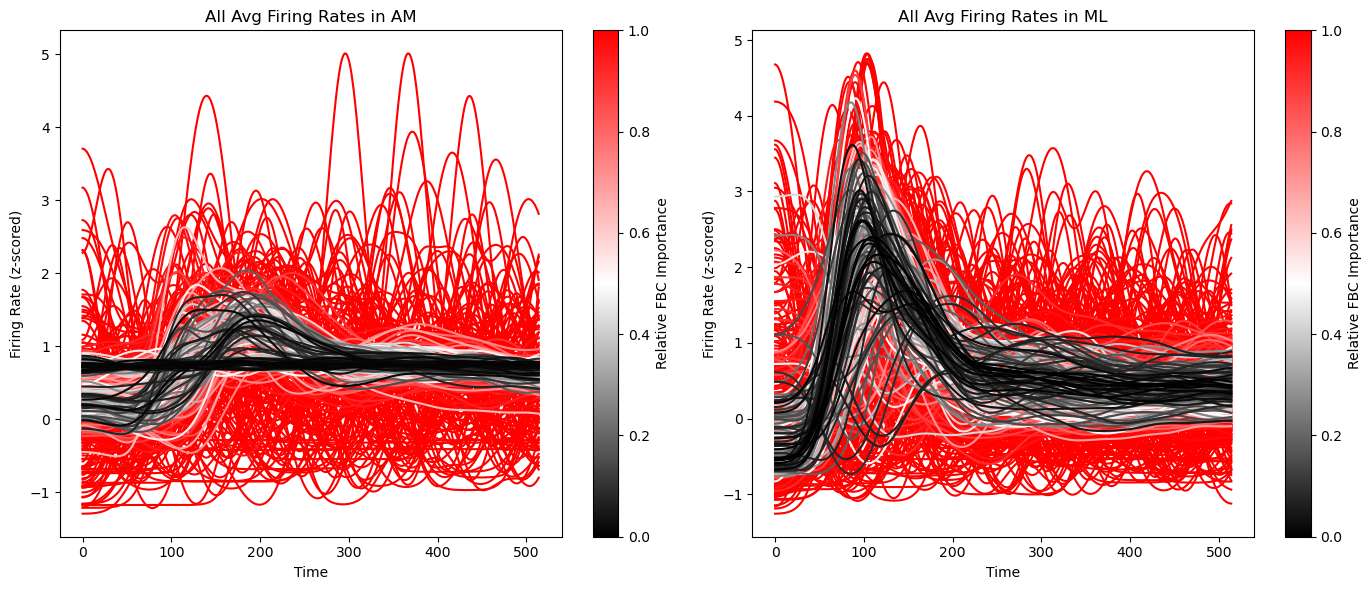

In [34]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

# Define the smoothing function
def smooth_array_with_gaussian(array, kernel_width=25):
    sigma = kernel_width / np.sqrt(8 * np.log(2))  # Convert kernel width to standard deviation
    smoothed_array = scipy.ndimage.gaussian_filter1d(array, sigma=sigma)
    return smoothed_array

# Assuming importance_scores, all_rates_AM, all_rates_ML, and median_stim_on_time are already defined
ffc_scores_am = importance_scores['AM']['PCA'][DIM]
fbc_scores_am = importance_scores['AM']['LQGCA'][DIM]
rel_FBC_import_am = fbc_scores_am / (fbc_scores_am + ffc_scores_am)

ffc_scores_ml = importance_scores['ML']['PCA'][DIM]
fbc_scores_ml = importance_scores['ML']['LQGCA'][DIM]
rel_FBC_import_ml = fbc_scores_ml / (fbc_scores_ml + ffc_scores_ml)

# Smooth firing rates
smoothed_AM = zsmooth_rates_AM[:, 0:int(median_stim_on_time)]
smoothed_ML = zsmooth_rates_ML[:, 0:int(median_stim_on_time)]

# Create a colormap
cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])

# Create the subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for AM region
for i in np.argsort(rel_FBC_import_am)[::-1]: #range(smoothed_AM.shape[0]):
    axes[0].plot(smoothed_AM[i], color=cmap(rel_FBC_import_am[i]))
axes[0].set_title("All Avg Firing Rates in AM")
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Firing Rate (z-scored)')

# Plot for ML region
for i in np.argsort(rel_FBC_import_ml)[::-1]: #range(smoothed_ML.shape[0]):
    axes[1].plot(smoothed_ML[i], color=cmap(rel_FBC_import_ml[i]))
axes[1].set_title("All Avg Firing Rates in ML")
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Firing Rate (z-scored)')

# Add colorbars
sm_am = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
sm_am.set_array([])
cbar_am = fig.colorbar(sm_am, ax=axes[0], orientation='vertical')
cbar_am.set_label('Relative FBC Importance')

sm_ml = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
sm_ml.set_array([])
cbar_ml = fig.colorbar(sm_ml, ax=axes[1], orientation='vertical')
cbar_ml.set_label('Relative FBC Importance')

plt.tight_layout()
plt.show()


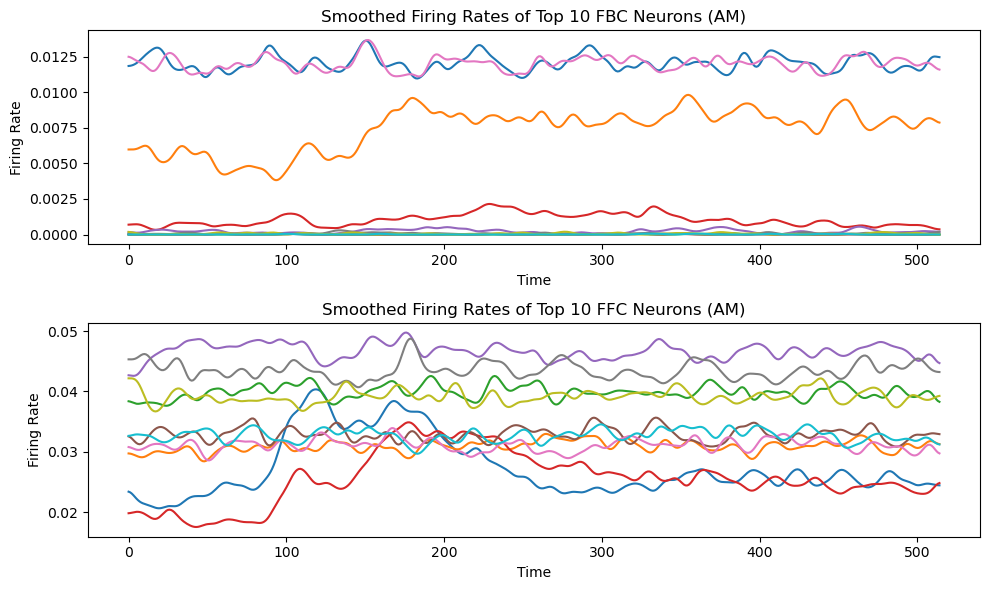

In [35]:
ffc_scores_am = importance_scores['AM']['PCA'][DIM]
fbc_scores_am = importance_scores['AM']['LQGCA'][DIM]


# Top 10 neurons by rel_FBC importance
top_neurons_inds = np.argsort(fbc_scores_am)[-10:]
top_firing_rates = all_rates_AM[top_neurons_inds, 0:int(median_stim_on_time)]
smoothed_top_firing_rates = np.apply_along_axis(smooth_array_with_gaussian, 1, top_firing_rates, kernel_width=10)

# 10 neurons with least rel_FBC importance
least_neurons_inds = np.argsort(ffc_scores_am)[-10:]
least_firing_rates = all_rates_AM[least_neurons_inds, 0:int(median_stim_on_time)]
smoothed_least_firing_rates = np.apply_along_axis(smooth_array_with_gaussian, 1, least_firing_rates, kernel_width=10)

# Create the subplot
plt.figure(figsize=(10, 6))

# Plot for top 10 neurons by rel_FBC importance
plt.subplot(2, 1, 1)
plt.title('Smoothed Firing Rates of Top 10 FBC Neurons (AM)')
for i in range(smoothed_top_firing_rates.shape[0]):
    plt.plot(smoothed_top_firing_rates[i]) #, label=f'Neuron {top_neurons_inds[i]}')
plt.xlabel('Time')
plt.ylabel('Firing Rate')
#plt.legend()

# Plot for 10 neurons with least rel_FBC importance
plt.subplot(2, 1, 2)
plt.title('Smoothed Firing Rates of Top 10 FFC Neurons (AM)')
for i in range(smoothed_least_firing_rates.shape[0]):
    plt.plot(smoothed_least_firing_rates[i]) #, label=f'Neuron {least_neurons_inds[i]}')
plt.xlabel('Time')
plt.ylabel('Firing Rate')
#plt.legend()

plt.tight_layout()
plt.show()


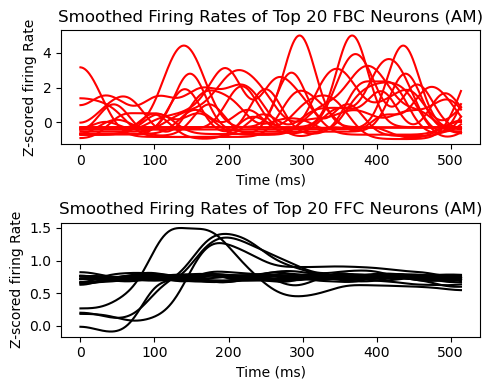

In [36]:
num_units = 20
ffc_scores_am = importance_scores['AM']['PCA'][DIM]
fbc_scores_am = importance_scores['AM']['LQGCA'][DIM]

rel_fbc = fbc_scores_am / (fbc_scores_am + ffc_scores_am)
rel_ffc = ffc_scores_am / (fbc_scores_am + ffc_scores_am)


# Top 10 neurons by rel_FBC importance
top_neurons_inds = np.argsort(rel_fbc)[-num_units:]
smoothed_top_firing_rates = zsmooth_rates_AM[top_neurons_inds, 0:int(median_stim_on_time)]
# 10 neurons with least rel_FBC importance
least_neurons_inds = np.argsort(rel_ffc)[-num_units:]
smoothed_least_firing_rates = zsmooth_rates_AM[least_neurons_inds, 0:int(median_stim_on_time)]

# Create the subplot
plt.figure(figsize=(5, 4))

# Plot for top 10 neurons by rel_FBC importance
plt.subplot(2, 1, 1)
plt.title(f'Smoothed Firing Rates of Top {num_units} FBC Neurons (AM)')
for i in range(smoothed_top_firing_rates.shape[0]):
    plt.plot(smoothed_top_firing_rates[i], color='red') #, label=f'Neuron {top_neurons_inds[i]}')
plt.xlabel('Time (ms)')
plt.ylabel('Z-scored firing Rate')
#plt.legend()

# Plot for 10 neurons with least rel_FBC importance
plt.subplot(2, 1, 2)
plt.title(f'Smoothed Firing Rates of Top {num_units} FFC Neurons (AM)')
for i in range(smoothed_least_firing_rates.shape[0]):
    plt.plot(smoothed_least_firing_rates[i], color='black') #, label=f'Neuron {least_neurons_inds[i]}')
plt.xlabel('Time (ms)')
plt.ylabel('Z-scored firing Rate')
#plt.legend()

plt.tight_layout()
plt.show()


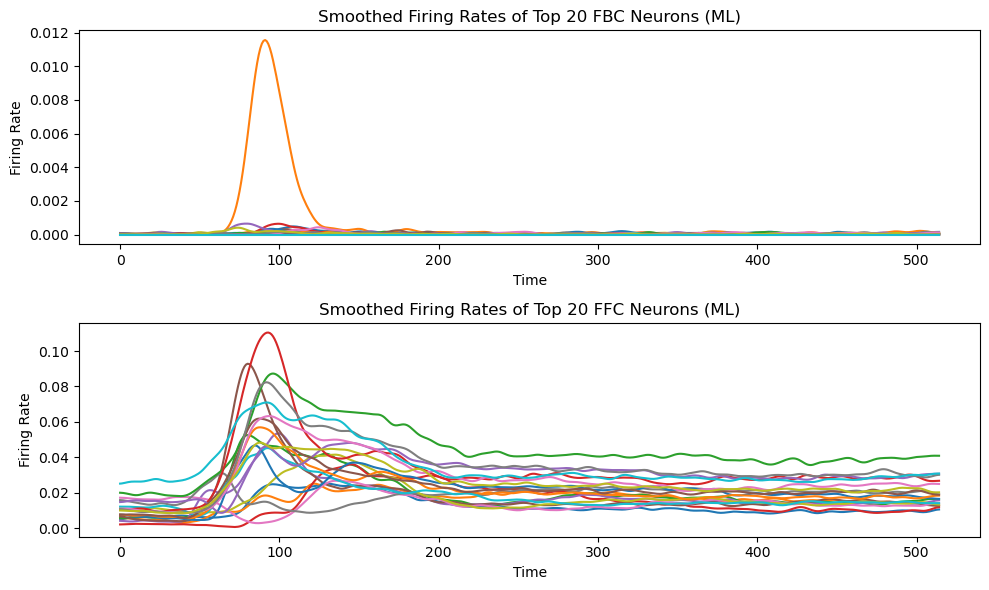

In [37]:
num_units = 20
ffc_scores_am = importance_scores['ML']['PCA'][DIM]
fbc_scores_am = importance_scores['ML']['LQGCA'][DIM]

# Top 10 neurons by rel_FBC importance
top_neurons_inds = np.argsort(fbc_scores_am)[-num_units:]
top_firing_rates = all_rates_ML[top_neurons_inds, 0:int(median_stim_on_time)]
smoothed_top_firing_rates = np.apply_along_axis(smooth_array_with_gaussian, 1, top_firing_rates, kernel_width=10)

# 10 neurons with least rel_FBC importance
least_neurons_inds = np.argsort(ffc_scores_am)[-num_units:]
least_firing_rates = all_rates_ML[least_neurons_inds, 0:int(median_stim_on_time)]
smoothed_least_firing_rates = np.apply_along_axis(smooth_array_with_gaussian, 1, least_firing_rates, kernel_width=10)

# Create the subplot
plt.figure(figsize=(10, 6))


max_ind = np.argsort(np.sum(smoothed_top_firing_rates, 1))[-1]
smoothed_top_firing_rates[max_ind,:] = np.zeros(np.shape(smoothed_top_firing_rates)[1])

# Plot for top 10 neurons by rel_FBC importance
plt.subplot(2, 1, 1)
plt.title(f'Smoothed Firing Rates of Top {num_units} FBC Neurons (ML)')
for i in range(smoothed_top_firing_rates.shape[0]):
    plt.plot(smoothed_top_firing_rates[i]) #, label=f'Neuron {top_neurons_inds[i]}')
plt.xlabel('Time')
plt.ylabel('Firing Rate')
#plt.legend()

# Plot for 10 neurons with least rel_FBC importance
plt.subplot(2, 1, 2)
plt.title(f'Smoothed Firing Rates of Top {num_units} FFC Neurons (ML)')
for i in range(smoothed_least_firing_rates.shape[0]):
    plt.plot(smoothed_least_firing_rates[i]) #, label=f'Neuron {least_neurons_inds[i]}')
plt.xlabel('Time')
plt.ylabel('Firing Rate')
#plt.legend()

plt.tight_layout()
plt.show()


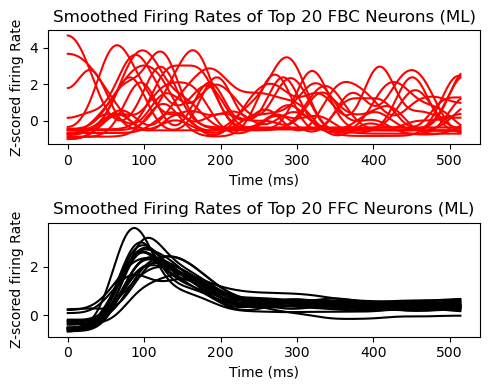

In [38]:
num_units = 20
ffc_scores_am = importance_scores['ML']['PCA'][DIM]
fbc_scores_am = importance_scores['ML']['LQGCA'][DIM]

rel_fbc = fbc_scores_am / (fbc_scores_am + ffc_scores_am)
rel_ffc = ffc_scores_am / (fbc_scores_am + ffc_scores_am)


# Top 10 neurons by rel_FBC importance
top_neurons_inds = np.argsort(rel_fbc)[-num_units:]
smoothed_top_firing_rates = zsmooth_rates_ML[top_neurons_inds, 0:int(median_stim_on_time)]
# 10 neurons with least rel_FBC importance
least_neurons_inds = np.argsort(rel_ffc)[-num_units:]
smoothed_least_firing_rates = zsmooth_rates_ML[least_neurons_inds, 0:int(median_stim_on_time)]

# Create the subplot
plt.figure(figsize=(5, 4))

# Plot for top 10 neurons by rel_FBC importance
plt.subplot(2, 1, 1)
plt.title(f'Smoothed Firing Rates of Top {num_units} FBC Neurons (ML)')
for i in range(smoothed_top_firing_rates.shape[0]):
    plt.plot(smoothed_top_firing_rates[i], color='red') #, label=f'Neuron {top_neurons_inds[i]}')
plt.xlabel('Time (ms)')
plt.ylabel('Z-scored firing Rate')
#plt.legend()

# Plot for 10 neurons with least rel_FBC importance
plt.subplot(2, 1, 2)
plt.title(f'Smoothed Firing Rates of Top {num_units} FFC Neurons (ML)')
for i in range(smoothed_least_firing_rates.shape[0]):
    plt.plot(smoothed_least_firing_rates[i], color='black') #, label=f'Neuron {least_neurons_inds[i]}')
plt.xlabel('Time (ms)')
plt.ylabel('Z-scored firing Rate')
#plt.legend()

plt.tight_layout()
plt.show()


### Plotting function of probe depth

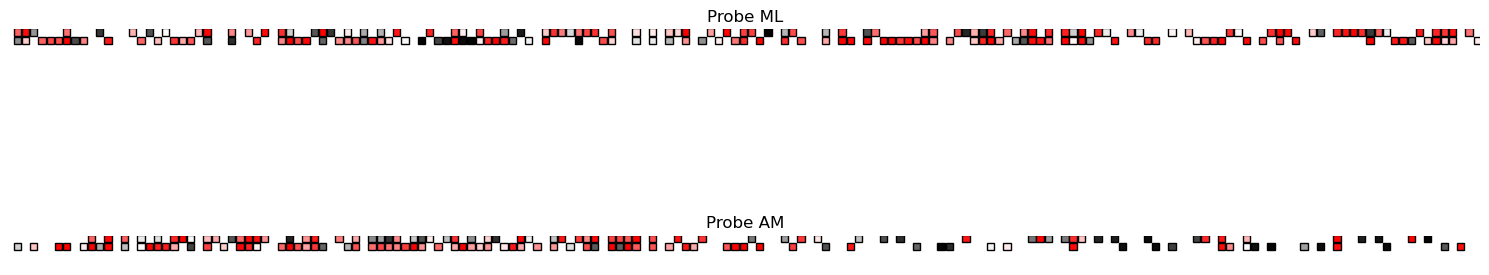

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Assuming importance_scores and AM_loaded_data are already defined and populated
channel_ids = np.array(AM_loaded_data['channelID'], dtype=int)
probe_ids = np.array(AM_loaded_data['probeID'], dtype=int)

# Ensure data alignment by filtering importance_scores based on channel_ids
region_ml = 'ML'
region_am = 'AM'
DIM = 21

# Create mapping of channels to importance scores for each region
ffc_scores_ml = importance_scores[region_ml]['PCA'][DIM]
fbc_scores_ml = importance_scores[region_ml]['LQGCA'][DIM]
ffc_scores_am = importance_scores[region_am]['PCA'][DIM]
fbc_scores_am = importance_scores[region_am]['LQGCA'][DIM]

# Compute relative FBC importance for each region
rel_FBC_import_ml = fbc_scores_ml / (fbc_scores_ml + ffc_scores_ml)
rel_FBC_import_am = fbc_scores_am / (fbc_scores_am + ffc_scores_am)

# Create a custom colormap from black to white to red
cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])

# Function to plot the probe with average color importance
def plot_probe_with_avg_color(ax, probe_channel_ids, rel_FBC_import, title):
    num_channels = 374
    contact_width = 40
    contact_height = 40
    contact_spacing = 5

    # Compute average rel_FBC_import for each contact
    avg_rel_FBC_import = np.array([
        np.mean(rel_FBC_import[probe_channel_ids == i]) if np.any(probe_channel_ids == i) else None
        for i in range(num_channels)
    ])

    # Plot the probe contacts
    for i in range(num_channels):
        if avg_rel_FBC_import[i] is None:
            continue  # Skip if no units on the contact

        # Calculate the position of each contact
        row = (i % 2) * (contact_height + contact_spacing)
        column = (i // 2) * (contact_width + contact_spacing)

        # Determine the facecolor
        facecolor = cmap(avg_rel_FBC_import[i])

        # Plot the contact
        rect = plt.Rectangle((column, row), contact_width, contact_height, edgecolor='black', facecolor=facecolor)
        ax.add_patch(rect)

    # Set plot limits and labels
    ax.set_xlim(-20, 8000)
    ax.set_ylim(-80, 80)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.axis('off')

# Filter data for ML and AM probes
ml_indices = probe_ids == 0
am_indices = probe_ids == 1

# Plot the probes one above the other
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot for ML (Probe 0)
plot_probe_with_avg_color(axes[0], channel_ids[ml_indices], rel_FBC_import_ml, 'Probe ML')

# Plot for AM (Probe 1)
plot_probe_with_avg_color(axes[1], channel_ids[am_indices], rel_FBC_import_am, 'Probe AM')

# Adjust the spacing between the subplots
plt.subplots_adjust(hspace=-0.75)

plt.tight_layout()
plt.show()


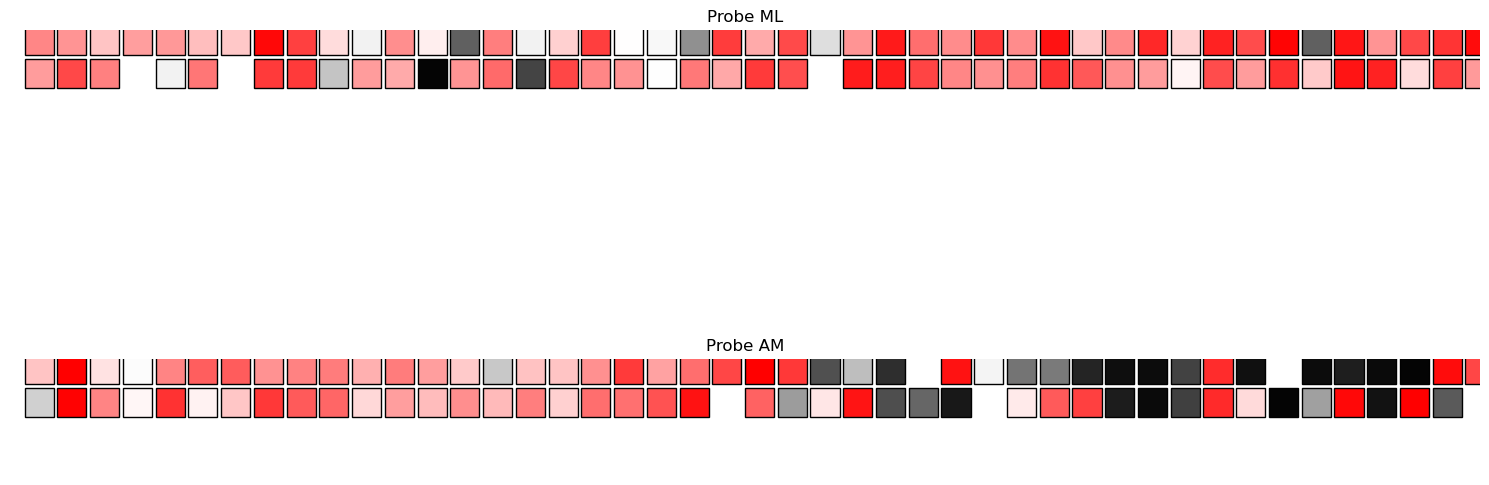

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Assuming importance_scores and AM_loaded_data are already defined and populated
channel_ids = np.array(AM_loaded_data['channelID'], dtype=int)
probe_ids = np.array(AM_loaded_data['probeID'], dtype=int)

# Ensure data alignment by filtering importance_scores based on channel_ids
region_ml = 'ML'
region_am = 'AM'
DIM = 21

# Create mapping of channels to importance scores for each region
ffc_scores_ml = importance_scores[region_ml]['PCA'][DIM]
fbc_scores_ml = importance_scores[region_ml]['LQGCA'][DIM]
ffc_scores_am = importance_scores[region_am]['PCA'][DIM]
fbc_scores_am = importance_scores[region_am]['LQGCA'][DIM]

# Compute relative FBC importance for each region
rel_FBC_import_ml = fbc_scores_ml / (fbc_scores_ml + ffc_scores_ml)
rel_FBC_import_am = fbc_scores_am / (fbc_scores_am + ffc_scores_am)

# Create a custom colormap from black to white to red
cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])

# Function to plot the probe with averaged color importance over groups of 4 channels
def plot_probe_with_avg_color(ax, probe_channel_ids, rel_FBC_import, title):
    num_channels = 374
    contact_width = 40
    contact_height = 40
    contact_spacing = 5

    # Compute average rel_FBC_import for each group of 4 channels
    avg_rel_FBC_import = []
    for i in range(0, num_channels, 4):
        channels_in_group = [probe_channel_ids == j for j in range(i, i + 4)]
        valid_channels = np.any(channels_in_group, axis=0)
        avg_rel_FBC_import.append(np.mean(rel_FBC_import[valid_channels]) if np.any(valid_channels) else None)
    
    # Plot the averaged contacts
    for i in range(len(avg_rel_FBC_import)):
        if avg_rel_FBC_import[i] is None:
            continue  # Skip if no units in the group

        # Calculate the position of each averaged contact
        row = (i % 2) * (contact_height + contact_spacing)
        column = (i // 2) * (contact_width + contact_spacing)

        # Determine the facecolor
        facecolor = cmap(avg_rel_FBC_import[i])

        # Plot the averaged contact
        rect = plt.Rectangle((column, row), contact_width, contact_height, edgecolor='black', facecolor=facecolor)
        ax.add_patch(rect)

    # Set plot limits and labels
    ax.set_xlim(-20, 8000 // 4)
    ax.set_ylim(-80, 80)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.axis('off')

# Filter data for ML and AM probes
ml_indices = probe_ids == 0
am_indices = probe_ids == 1

# Plot the probes one above the other
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot for ML (Probe 0)
plot_probe_with_avg_color(axes[0], channel_ids[ml_indices], rel_FBC_import_ml, 'Probe ML')

# Plot for AM (Probe 1)
plot_probe_with_avg_color(axes[1], channel_ids[am_indices], rel_FBC_import_am, 'Probe AM')

plt.subplots_adjust(hspace=-0.25)
plt.tight_layout()
plt.show()


## Plotting waveforms

In [41]:
ML_loaded_data.keys()

dict_keys(['ParadigmName', 'probeID', 'channelID', 'waveforms', 'waveforms_time', 'Regions', 'regionIDs', 'NumUnits', 'NumTrials', 'TrialStartTimes', 'StimulusOnDurations', 'StimulusOFFDurations', 'StimulusNames', 'StimIDs', 'behavior', 'TrialDurations', 'bin_width', 'SessionName', 'spike_times', 'spike_rates', 'stratifiedIDs', 'degradedIDs'])

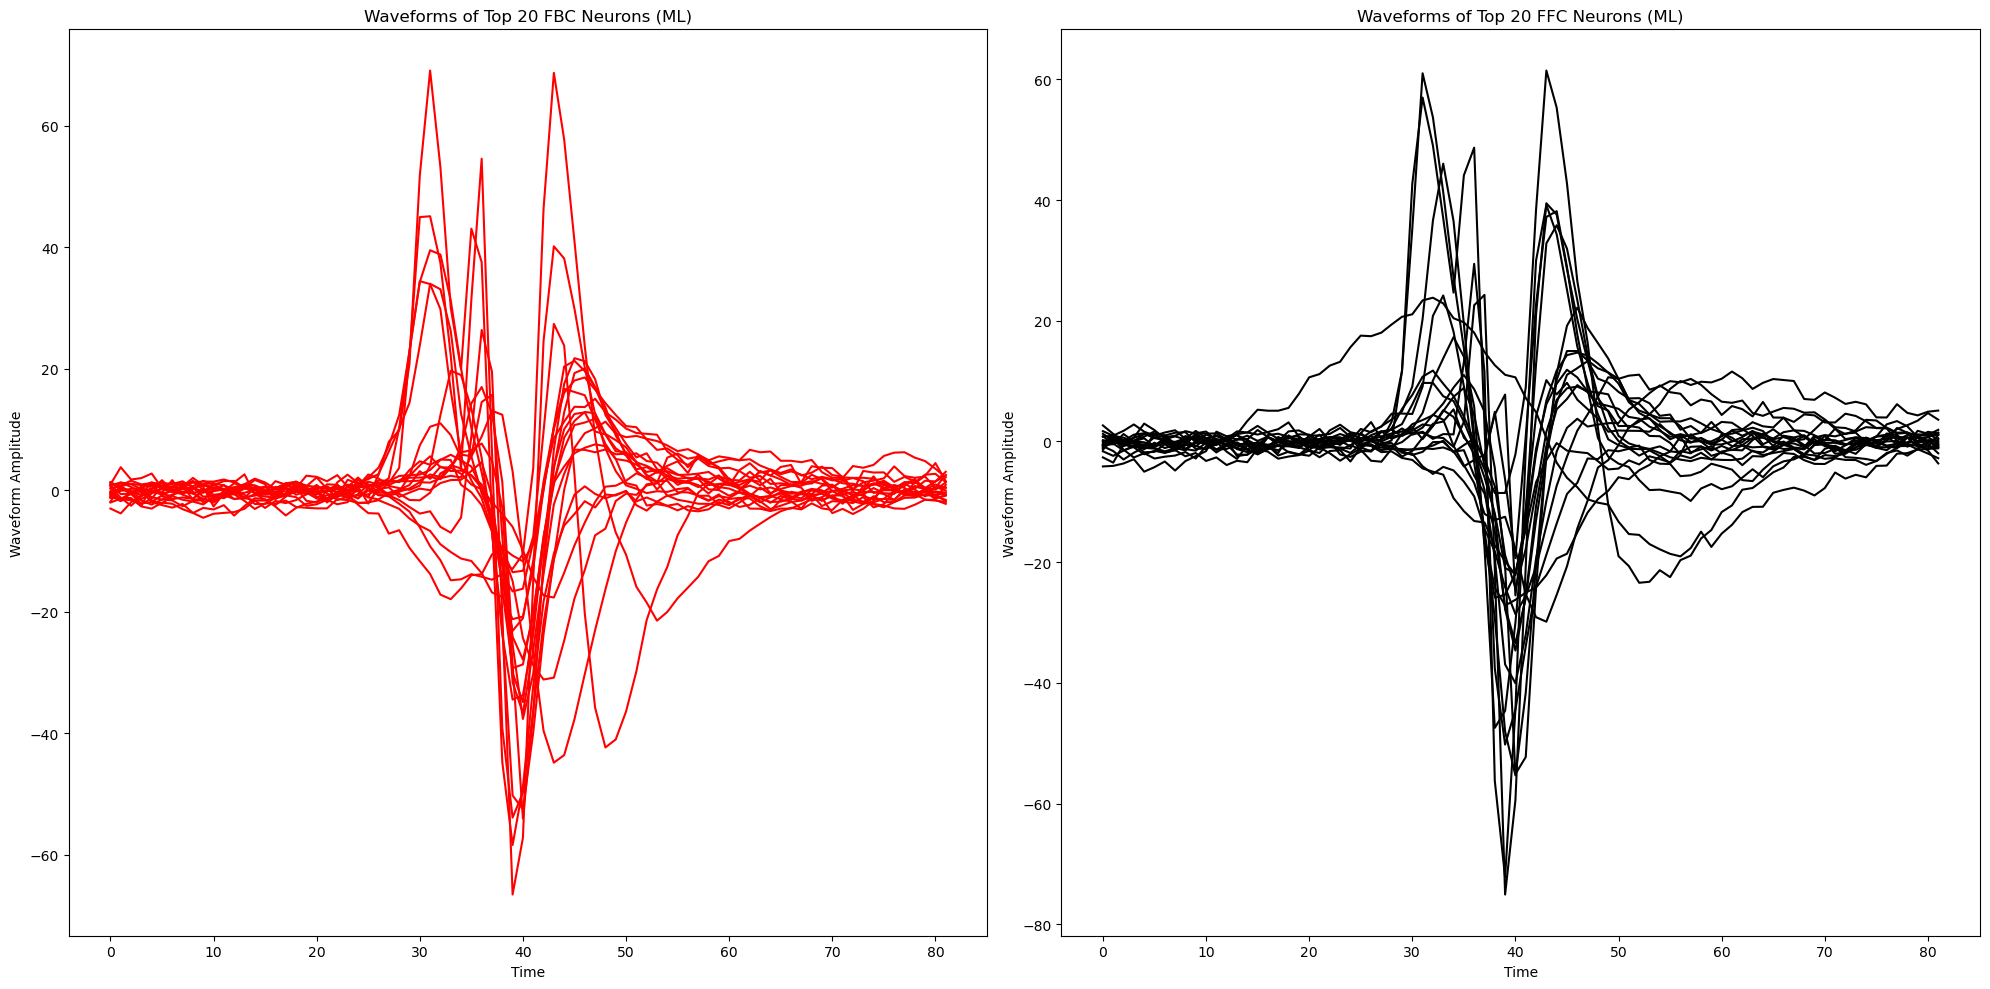

In [42]:
top_n_units = 20

ffc_scores_ml = importance_scores['ML']['PCA'][DIM]
fbc_scores_ml = importance_scores['ML']['LQGCA'][DIM]
ML_waveforms = ML_loaded_data['waveforms'][ML_loaded_data['probeID'] == 0]

rel_fbc = fbc_scores_am / (fbc_scores_am + ffc_scores_am)
rel_ffc = ffc_scores_am / (fbc_scores_am + ffc_scores_am)

sort_vals_fbc = rel_fbc #fbc_scores_ml #
sort_vals_ffc = rel_ffc #ffc_scores_ml #

# Top 10 neurons by FBC importance
top_neurons_inds_fbc = np.argsort(sort_vals_fbc)[-top_n_units:][::-1]
top_waveforms_fbc = ML_waveforms[top_neurons_inds_fbc, :]
top_waveforms_fbc = top_waveforms_fbc - np.mean(top_waveforms_fbc, axis=1, keepdims=True)

# Top 10 neurons by FFC importance
top_neurons_inds_ffc = np.argsort(sort_vals_ffc)[-top_n_units:][::-1]
top_waveforms_ffc = ML_waveforms[top_neurons_inds_ffc, :]
top_waveforms_ffc = top_waveforms_ffc - np.mean(top_waveforms_ffc, axis=1, keepdims=True)

# Create the subplot
plt.figure(figsize=(20, 10))

# Plot for top 10 neurons by FBC importance
plt.subplot(1, 2, 1)
plt.title(f'Waveforms of Top {top_n_units} FBC Neurons (ML)')
for i in range(top_waveforms_fbc.shape[0]):
    plt.plot(top_waveforms_fbc[i], color='red') #, label=f'Neuron {top_neurons_inds_fbc[i]}')
plt.xlabel('Time')
plt.ylabel('Waveform Amplitude')
#plt.legend()

# Plot for top 10 neurons by FFC importance
plt.subplot(1, 2, 2)
plt.title(f'Waveforms of Top {top_n_units} FFC Neurons (ML)')
for i in range(top_waveforms_ffc.shape[0]):
    plt.plot(top_waveforms_ffc[i], color='black') #, label=f'Neuron {top_neurons_inds_ffc[i]}')
plt.xlabel('Time')
plt.ylabel('Waveform Amplitude')
#plt.legend()

plt.tight_layout()
plt.show()


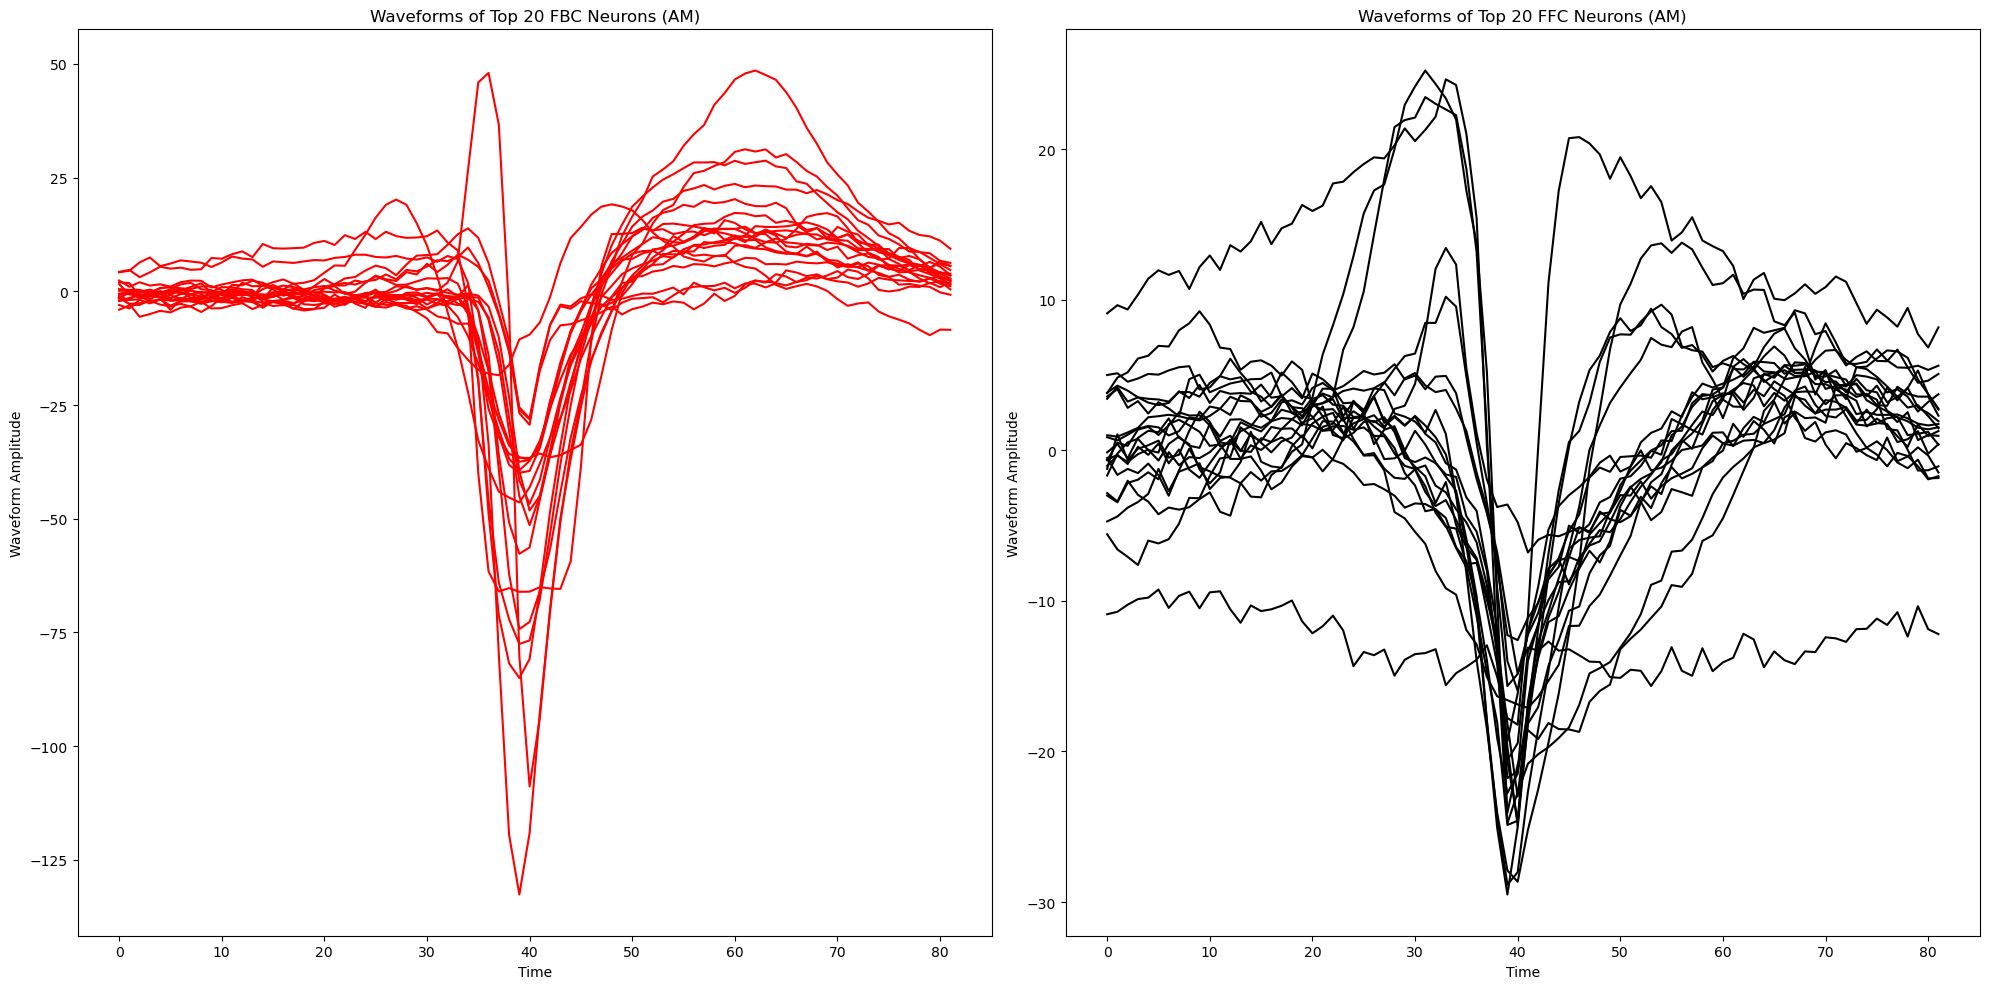

In [43]:
top_n_units = 20

ffc_scores_am = importance_scores['AM']['PCA'][DIM]
fbc_scores_am = importance_scores['AM']['LQGCA'][DIM]
AM_waveforms = AM_loaded_data['waveforms'][AM_loaded_data['probeID'] == 1]

rel_fbc = fbc_scores_am / (fbc_scores_am + ffc_scores_am)
rel_ffc = ffc_scores_am / (fbc_scores_am + ffc_scores_am)

sort_vals_fbc = rel_fbc #fbc_scores_am #
sort_vals_ffc = rel_ffc #ffc_scores_am #

# Top 10 neurons by FBC importance
top_neurons_inds_fbc = np.argsort(sort_vals_fbc)[-top_n_units:][::-1]
top_waveforms_fbc = AM_waveforms[top_neurons_inds_fbc, :]
top_waveforms_fbc = top_waveforms_fbc - np.mean(top_waveforms_fbc, axis=1, keepdims=True)

# Top 10 neurons by FFC importance
top_neurons_inds_ffc = np.argsort(sort_vals_ffc)[-top_n_units:][::-1]
top_waveforms_ffc = AM_waveforms[top_neurons_inds_ffc, :]
top_waveforms_ffc = top_waveforms_ffc - np.mean(top_waveforms_ffc, axis=1, keepdims=True)

# Create the subplot
plt.figure(figsize=(20, 10))

# Plot for top 10 neurons by FBC importance
plt.subplot(1, 2, 1)
plt.title(f'Waveforms of Top {top_n_units} FBC Neurons (AM)')
for i in range(top_waveforms_fbc.shape[0]):
    plt.plot(top_waveforms_fbc[i], color='red') #, label=f'Neuron {top_neurons_inds_fbc[i]}')
plt.xlabel('Time')
plt.ylabel('Waveform Amplitude')
#plt.legend()

# Plot for top 10 neurons by FFC importance
plt.subplot(1, 2, 2)
plt.title(f'Waveforms of Top {top_n_units} FFC Neurons (AM)')
for i in range(top_waveforms_ffc.shape[0]):
    plt.plot(top_waveforms_ffc[i], color='black') #, label=f'Neuron {top_neurons_inds_ffc[i]}')
plt.xlabel('Time')
plt.ylabel('Waveform Amplitude')
#plt.legend()

plt.tight_layout()
plt.show()


In [44]:
AM_sp_counts = np.sum(AM_loaded_data['spike_rates'], axis=(0,1))
ML_sp_counts = np.sum(ML_loaded_data['spike_rates'], axis=(0,1))

In [45]:
np.shape(AM_loaded_data['spike_times'])

(1991, 371)

In [46]:
np.shape(AM_loaded_data['spike_times'][:, 0])

(1991,)

In [47]:
AM_loaded_data['spike_times'][:, 0][1][0]

array([ 11,  56, 637, 658, 766])

In [48]:
AM_sp_times = AM_loaded_data['spike_times']
num_AM_units = AM_sp_times.shape[1]
AM_sp_counts = np.zeros(num_AM_units)
AM_spontaneous_counts = np.zeros(num_AM_units)

for am_unit in np.arange(num_AM_units):

    count = 0
    sp_count = 0
    unit_times = AM_sp_times[:, am_unit]

    for trial in np.arange(len(unit_times)):
        trial_sp_times = unit_times[trial][0]
        count += len(trial_sp_times)
        sp_count += len(trial_sp_times[trial_sp_times > median_stim_on_time + 20])

    AM_sp_counts[am_unit] = count
    AM_spontaneous_counts[am_unit] = sp_count


ML_sp_times = ML_loaded_data['spike_times']
num_ML_units = ML_sp_times.shape[1]
ML_sp_counts = np.zeros(num_ML_units)
ML_spontaneous_counts = np.zeros(num_ML_units)
for ml_unit in np.arange(num_ML_units):

    count = 0
    sp_count = 0
    unit_times = ML_sp_times[:, ml_unit]

    for trial in np.arange(len(unit_times)):
        trial_sp_times = unit_times[trial][0]
        count += len(trial_sp_times)
        sp_count += len(trial_sp_times[trial_sp_times > median_stim_on_time + 20])

    ML_sp_counts[ml_unit] = count
    ML_spontaneous_counts[am_unit] = sp_count



Text(0.5, 1.0, 'ML')

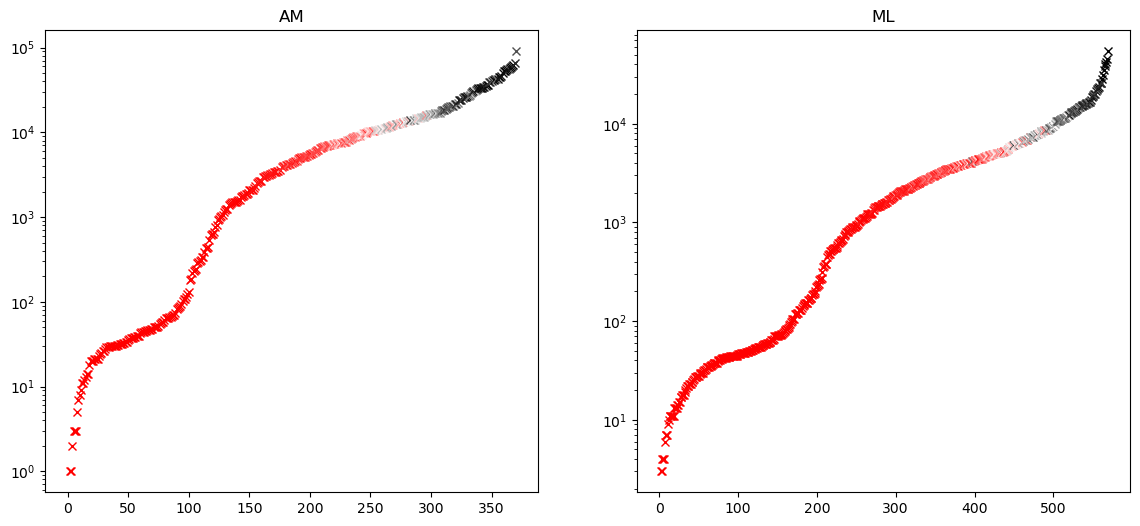

In [49]:
DIM = 21
ffc_scores_am = importance_scores['AM']['PCA'][DIM]
fbc_scores_am = importance_scores['AM']['LQGCA'][DIM]
rel_FBC_import_am = fbc_scores_am / (fbc_scores_am + ffc_scores_am)

ffc_scores_ml = importance_scores['ML']['PCA'][DIM]
fbc_scores_ml = importance_scores['ML']['LQGCA'][DIM]
rel_FBC_import_ml = fbc_scores_ml / (fbc_scores_ml + ffc_scores_ml)


cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


AM_counts_inds = np.argsort(AM_sp_counts)
AM_sp_counts_srt = AM_sp_counts[AM_counts_inds]
for ind, val in enumerate(AM_sp_counts_srt): 
    axes[0].plot(ind, val, 'x' , color=cmap(rel_FBC_import_am[AM_counts_inds[ind]]))
axes[0].set_yscale('log')
axes[0].set_title("AM")



ML_counts_inds = np.argsort(ML_sp_counts)
ML_sp_counts_srt = ML_sp_counts[ML_counts_inds]
for ind, val in enumerate(ML_sp_counts_srt): 
    axes[1].plot(ind, val, 'x' , color=cmap(rel_FBC_import_ml[ML_counts_inds[ind]]))
axes[1].set_yscale('log')
axes[1].set_title("ML")



Text(0.5, 1.0, 'ML Spontaneous')

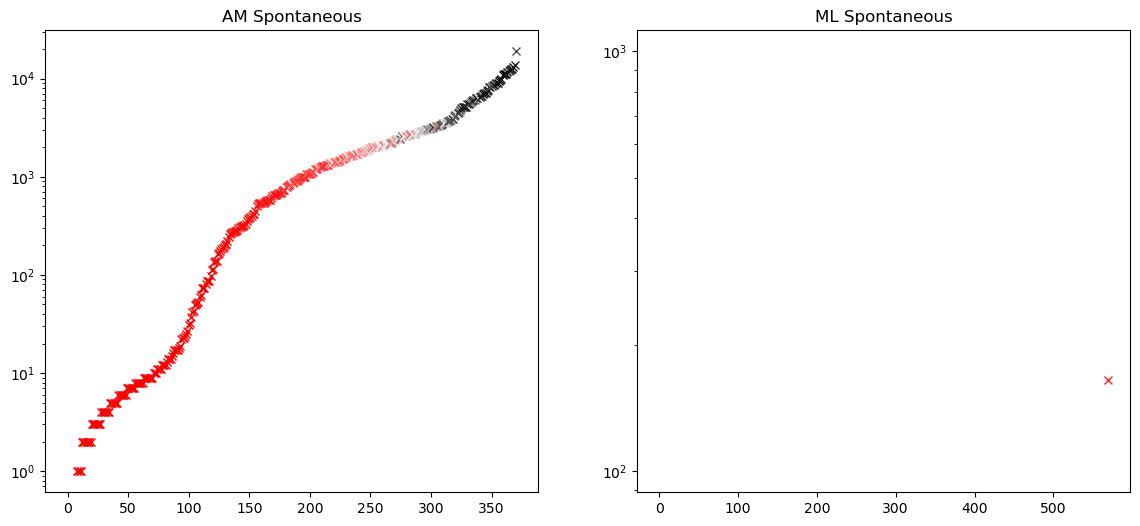

In [50]:
DIM = 21
ffc_scores_am = importance_scores['AM']['PCA'][DIM]
fbc_scores_am = importance_scores['AM']['LQGCA'][DIM]
rel_FBC_import_am = fbc_scores_am / (fbc_scores_am + ffc_scores_am)

ffc_scores_ml = importance_scores['ML']['PCA'][DIM]
fbc_scores_ml = importance_scores['ML']['LQGCA'][DIM]
rel_FBC_import_ml = fbc_scores_ml / (fbc_scores_ml + ffc_scores_ml)


cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


AM_counts_inds = np.argsort(AM_spontaneous_counts)
AM_sp_counts_srt = AM_spontaneous_counts[AM_counts_inds]
for ind, val in enumerate(AM_sp_counts_srt): 
    axes[0].plot(ind, val, 'x' , color=cmap(rel_FBC_import_am[AM_counts_inds[ind]]))
axes[0].set_yscale('log')
axes[0].set_title("AM Spontaneous")



ML_counts_inds = np.argsort(ML_spontaneous_counts)
ML_sp_counts_srt = ML_spontaneous_counts[ML_counts_inds]
for ind, val in enumerate(ML_sp_counts_srt): 
    axes[1].plot(ind, val, 'x' , color=cmap(rel_FBC_import_ml[ML_counts_inds[ind]]))
axes[1].set_yscale('log')
axes[1].set_title("ML Spontaneous")



In [51]:
ML_sp_counts.shape

(570,)

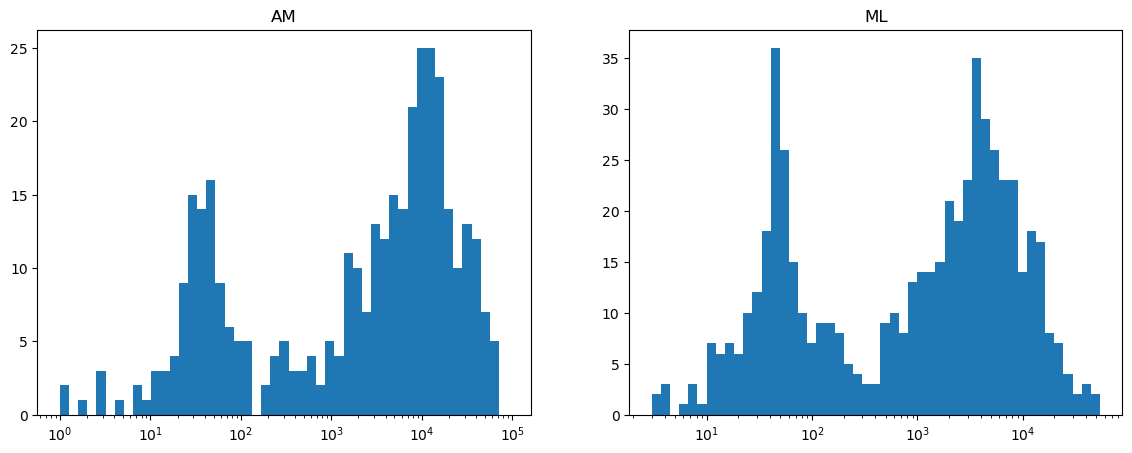

In [52]:
plt.figure(figsize=(14, 5))
nBins = 50


plt.subplot(1,2,1)
AM_sp_counts_filt = AM_sp_counts[AM_sp_counts > 0]
bins = np.logspace(np.log10(min(AM_sp_counts_filt)), np.log10(max(AM_sp_counts_filt)), num=nBins)
plt.hist(AM_sp_counts_filt, bins=bins);
plt.title("AM")
plt.xscale('log')


plt.subplot(1,2,2)
ML_sp_counts_filt = ML_sp_counts[ML_sp_counts > 0]
bins = np.logspace(np.log10(min(ML_sp_counts_filt)), np.log10(max(ML_sp_counts_filt)), num=nBins)
plt.hist(ML_sp_counts_filt, bins=bins);
plt.title("ML")
plt.xscale('log')



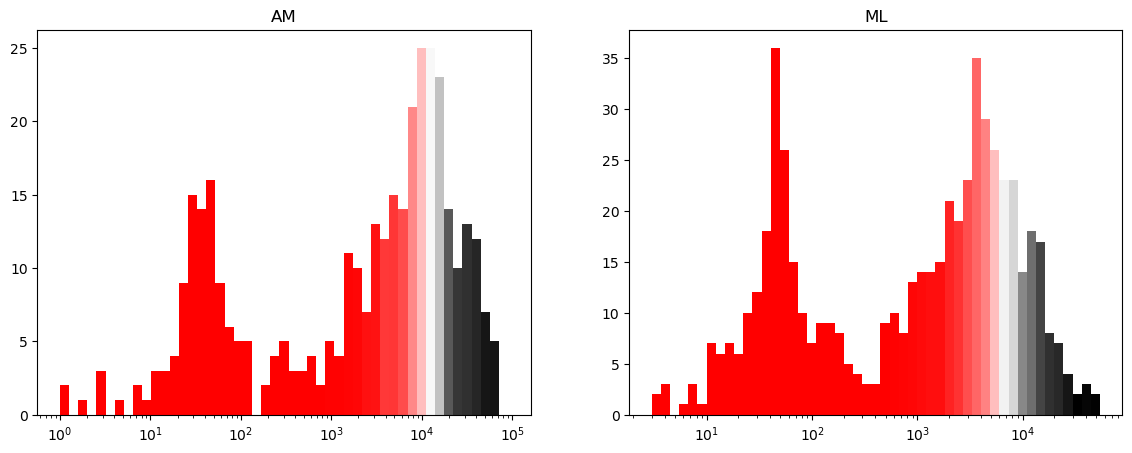

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define data and importance scores
ffc_scores_am = importance_scores['AM']['PCA'][DIM]
fbc_scores_am = importance_scores['AM']['LQGCA'][DIM]
rel_FBC_import_am = fbc_scores_am / (fbc_scores_am + ffc_scores_am)

ffc_scores_ml = importance_scores['ML']['PCA'][DIM]
fbc_scores_ml = importance_scores['ML']['LQGCA'][DIM]
rel_FBC_import_ml = fbc_scores_ml / (fbc_scores_ml + ffc_scores_ml)

cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])

# Function to create histogram with colored bins
def create_hist_with_colored_bins(ax, sp_counts, rel_FBC_import, title):
    # Ensure the lengths match by filtering valid spike counts and corresponding rel_FBC_import values
    valid_indices = sp_counts > 0
    sp_counts = sp_counts[valid_indices]
    rel_FBC_import = rel_FBC_import[valid_indices]

    # Verify the lengths after filtering
    assert len(sp_counts) == len(rel_FBC_import), "Lengths of sp_counts and rel_FBC_import do not match after filtering"

    bins = np.logspace(np.log10(min(sp_counts)), np.log10(max(sp_counts)), num=nBins)

    n, bins, patches = ax.hist(sp_counts, bins=bins)

    for i in range(len(patches)):
        bin_left = bins[i]
        bin_right = bins[i + 1]
        # Select the neurons in this bin
        in_bin = (sp_counts >= bin_left) & (sp_counts < bin_right)
        if np.any(in_bin):
            # Calculate the average relative FBC score for this bin
            avg_rel_FBC = np.mean(rel_FBC_import[in_bin])
            color = cmap(avg_rel_FBC)
        else:
            color = 'gray'  # Default color if no data in bin
        patches[i].set_facecolor(color)

    ax.set_xscale('log')
    ax.set_title(title)

# Plot the histograms
plt.figure(figsize=(14, 5))
nBins = 50

plt.subplot(1, 2, 1)
create_hist_with_colored_bins(plt.gca(), AM_sp_counts, rel_FBC_import_am, "AM")

plt.subplot(1, 2, 2)
create_hist_with_colored_bins(plt.gca(), ML_sp_counts, rel_FBC_import_ml, "ML")

plt.show()


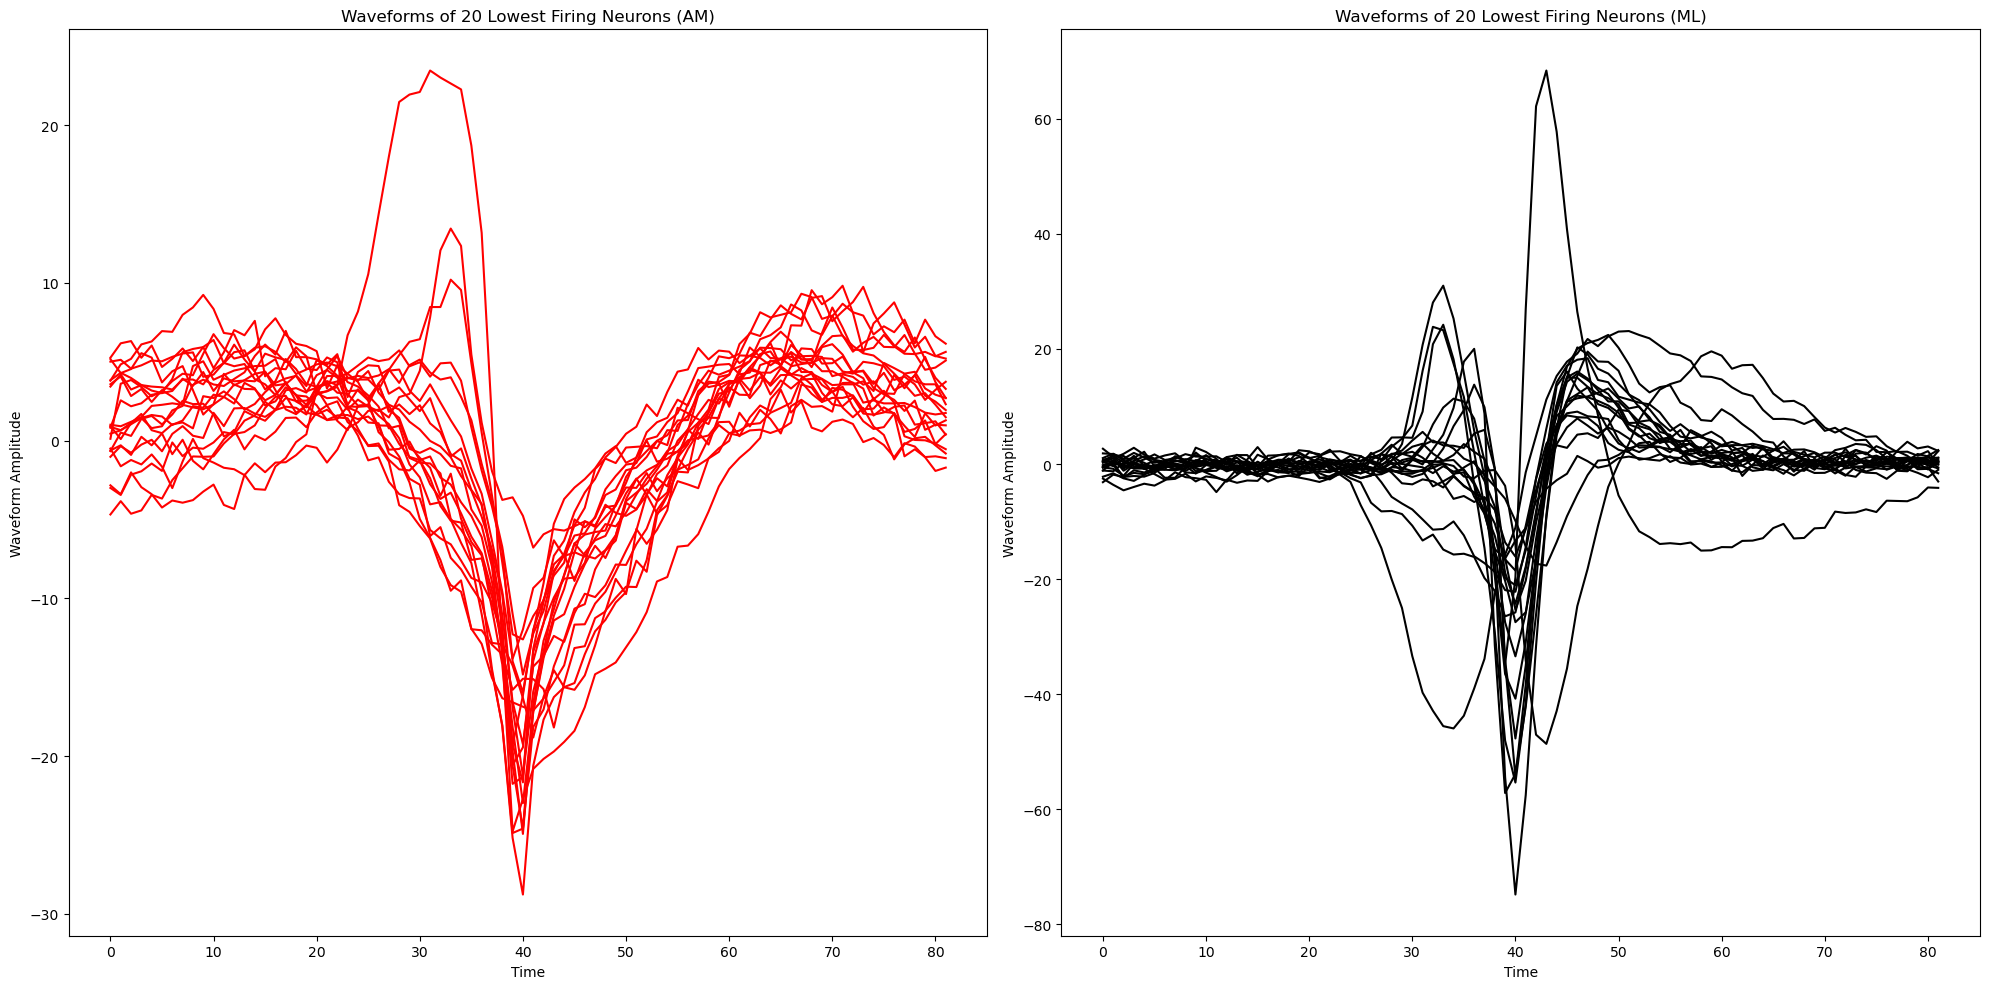

In [54]:
top_n_units = 20

ML_count_inds = np.argsort(ML_sp_counts)[::-1]
AM_count_inds = np.argsort(AM_sp_counts)[::-1]

am_inds = AM_count_inds[:top_n_units]
ml_inds = ML_count_inds[:top_n_units]

AM_waveforms = AM_loaded_data['waveforms'][AM_loaded_data['probeID'] == 1]
ML_waveforms = ML_loaded_data['waveforms'][ML_loaded_data['probeID'] == 0]


# Top 10 neurons by FBC importance
AM_low_wvfrms = AM_waveforms[am_inds, :]
AM_low_wvfrms = AM_low_wvfrms - np.mean(AM_low_wvfrms, axis=1, keepdims=True)

# Top 10 neurons by FFC importance
ML_low_wvfrms = ML_waveforms[ml_inds, :]
ML_low_wvfrms = ML_low_wvfrms - np.mean(ML_low_wvfrms, axis=1, keepdims=True)

# Create the subplot
plt.figure(figsize=(20, 10))

# Plot for top 10 neurons by FBC importance
plt.subplot(1, 2, 1)
plt.title(f'Waveforms of {top_n_units} Lowest Firing Neurons (AM)')
for i in range(AM_low_wvfrms.shape[0]):
    plt.plot(AM_low_wvfrms[i], color='red') #, label=f'Neuron {top_neurons_inds_fbc[i]}')
plt.xlabel('Time')
plt.ylabel('Waveform Amplitude')
#plt.legend()

# Plot for top 10 neurons by FFC importance
plt.subplot(1, 2, 2)
plt.title(f'Waveforms of {top_n_units} Lowest Firing Neurons (ML)')
for i in range(ML_low_wvfrms.shape[0]):
    plt.plot(ML_low_wvfrms[i], color='black') #, label=f'Neuron {top_neurons_inds_ffc[i]}')
plt.xlabel('Time')
plt.ylabel('Waveform Amplitude')
#plt.legend()

plt.tight_layout()
plt.show()


In [55]:
AM_pseudo_rasters = {}
window = 800

for unit in np.arange(AM_sp_times.shape[1]):

    AM_pseudo_rasters[unit] = []

    for trial in np.arange(AM_sp_times.shape[0]):

        
        sp_times = AM_sp_times[trial, unit][0]
        sp_times = sp_times[sp_times < window] # cap to 800ms

        AM_pseudo_rasters[unit] = np.hstack((AM_pseudo_rasters[unit], sp_times + trial*window))



ML_pseudo_rasters = {}

for unit in np.arange(ML_sp_times.shape[1]):

    ML_pseudo_rasters[unit] = []

    for trial in np.arange(ML_sp_times.shape[0]):

        
        sp_times = ML_sp_times[trial, unit][0]
        sp_times = sp_times[sp_times < window] # cap to 800ms

        ML_pseudo_rasters[unit] = np.hstack((ML_pseudo_rasters[unit], sp_times + trial*window))




Text(0.5, 1.0, 'ML')

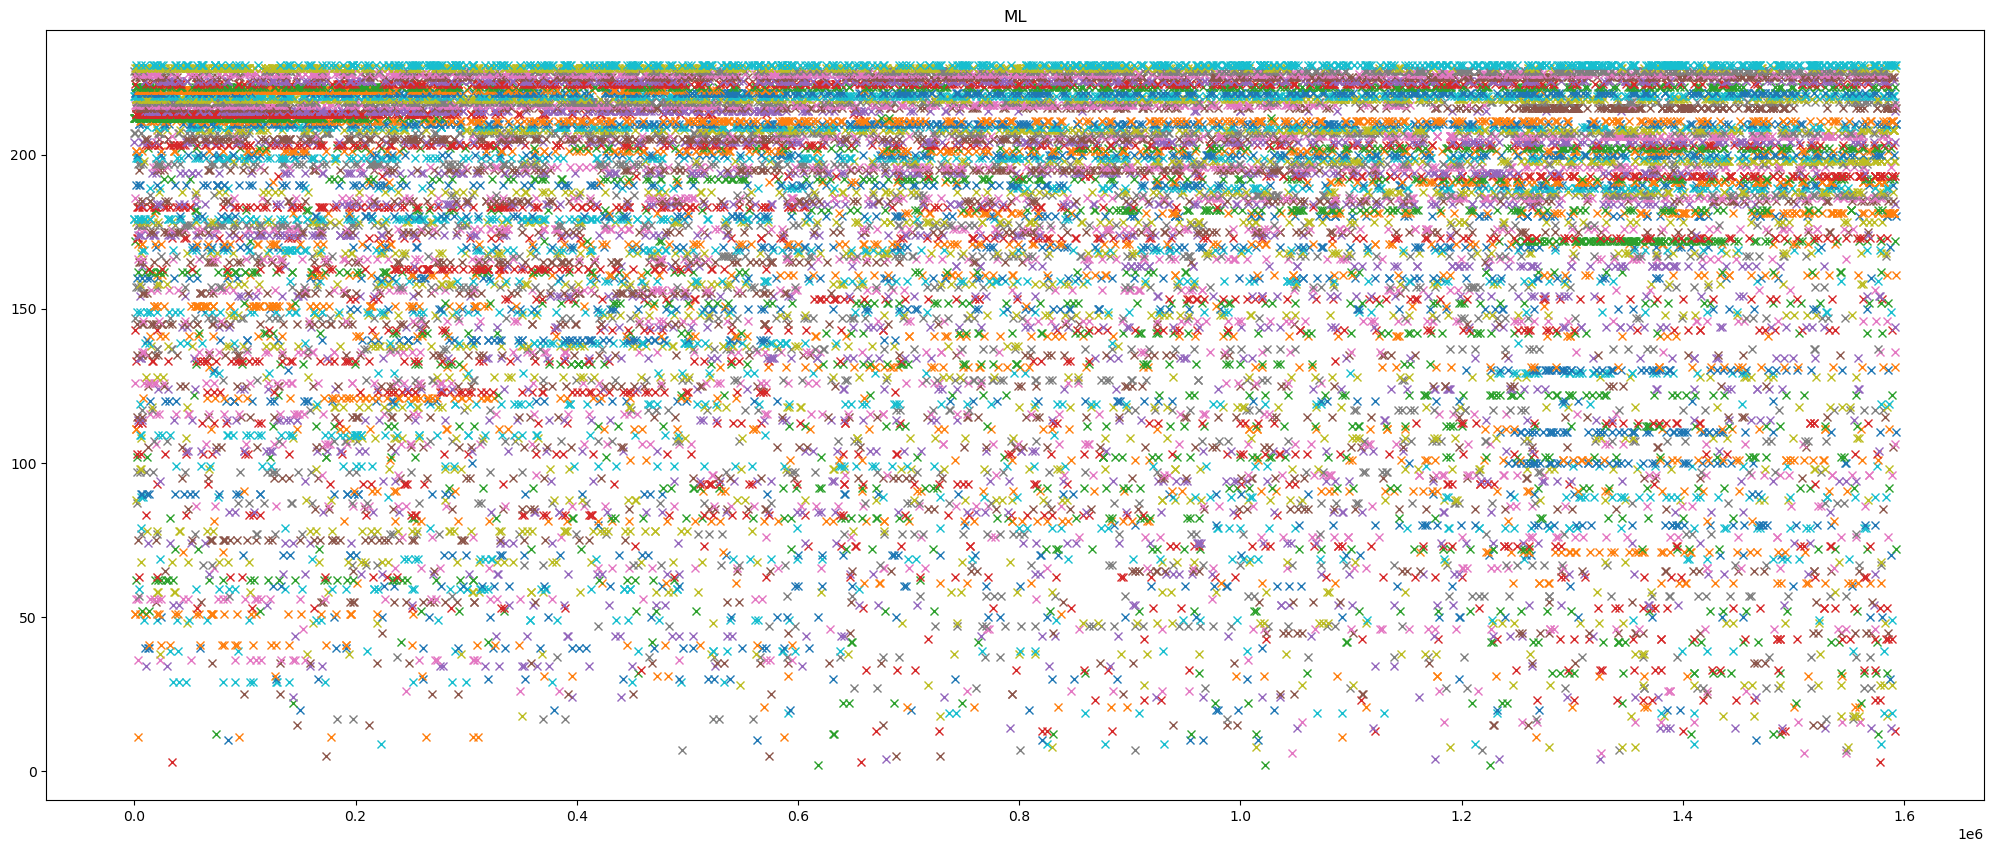

In [56]:
num_plot_neurons = 230
sort_inds = np.argsort(ML_sp_counts)
plt.figure(figsize=(25, 10))

for ind, unit in enumerate(sort_inds[:num_plot_neurons]):
    plt.plot(ML_pseudo_rasters[unit], ind*np.ones(len(ML_pseudo_rasters[unit])) , 'x')
plt.title('ML')
#plt.vlines(window*np.arange(AM_sp_times.shape[0]), ymin=0, ymax=2)

Text(0.5, 1.0, 'AM')

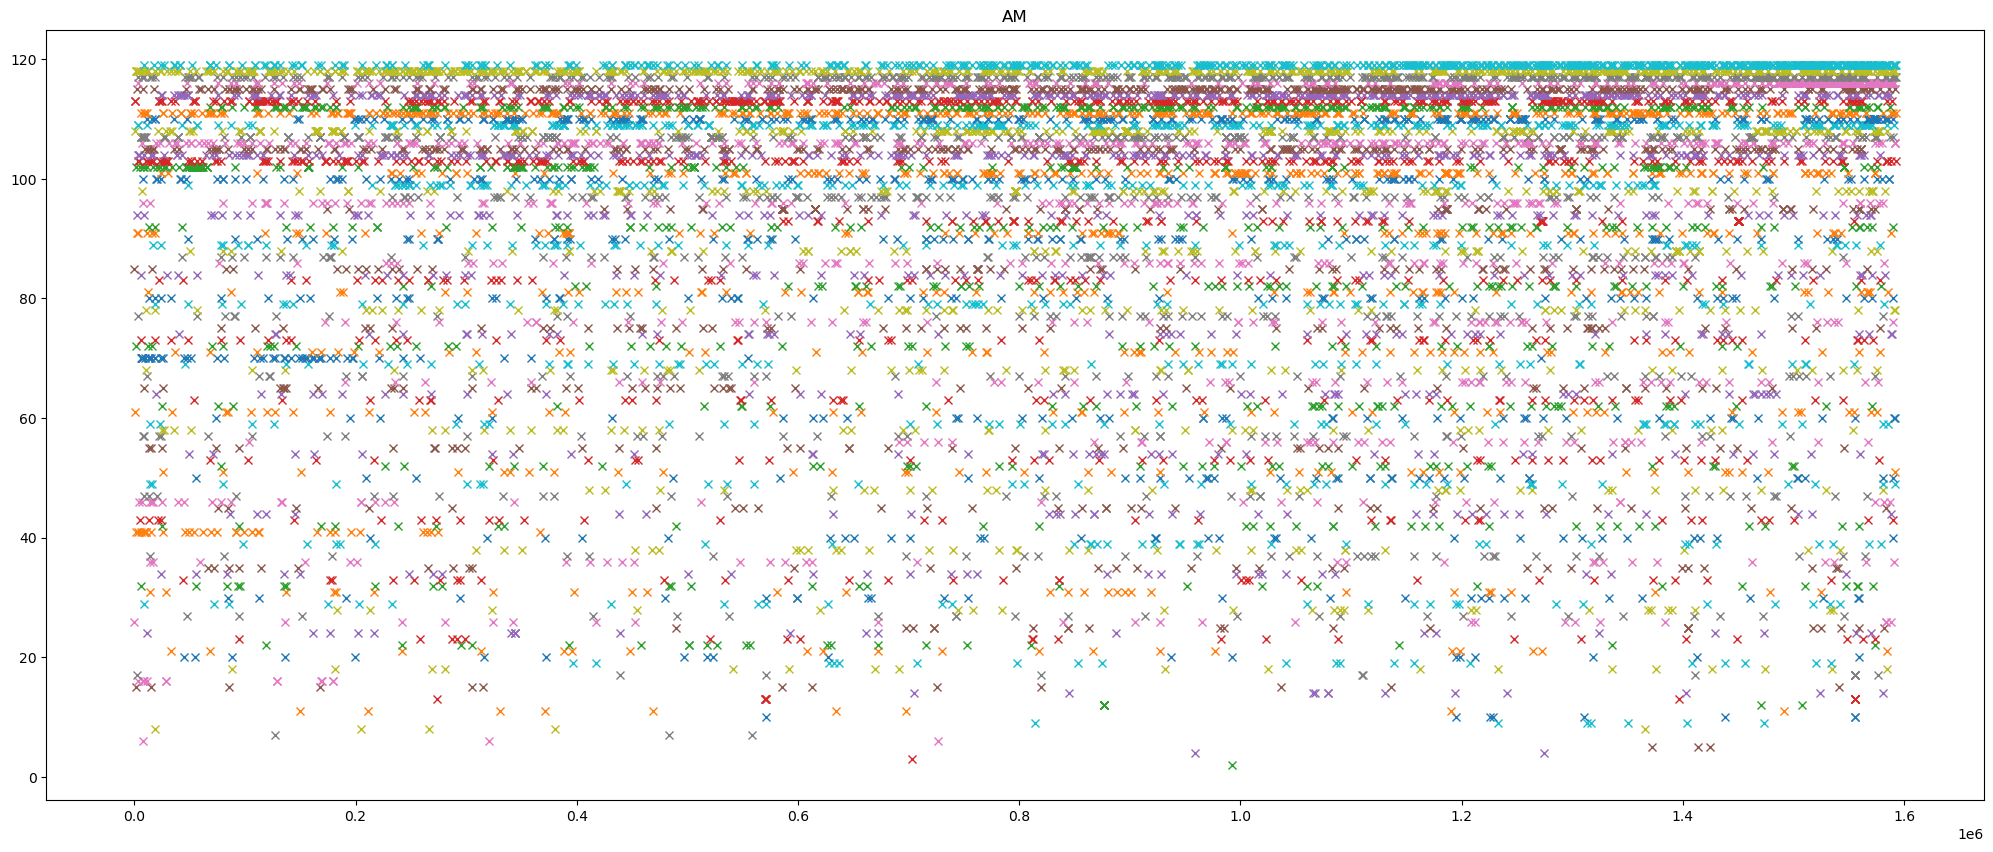

In [57]:
num_plot_neurons = 120

sort_inds = np.argsort(AM_sp_counts)

plt.figure(figsize=(25, 10))

for ind, unit in enumerate(sort_inds[:num_plot_neurons]):
    plt.plot(AM_pseudo_rasters[unit], ind*np.ones(len(AM_pseudo_rasters[unit])) , 'x')
plt.title('AM')



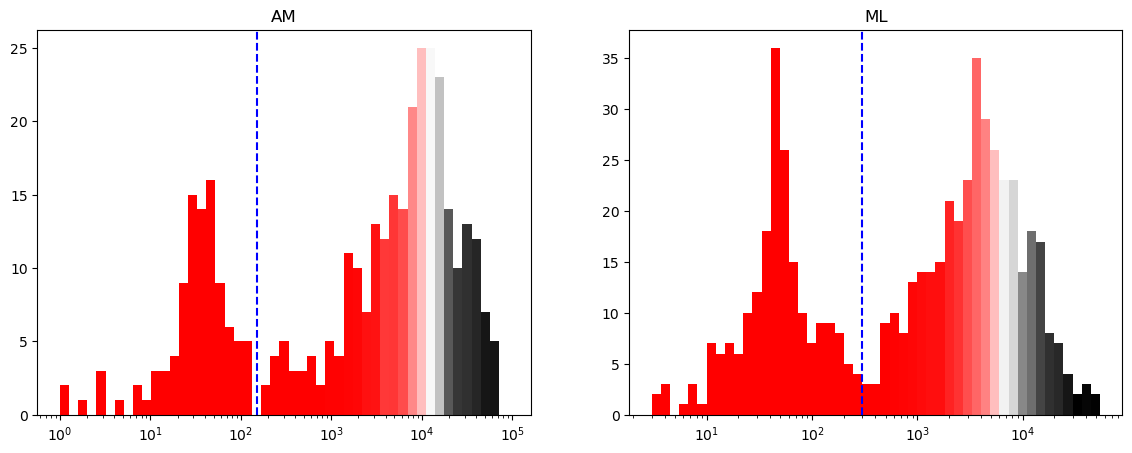

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define data and importance scores
ffc_scores_am = importance_scores['AM']['PCA'][DIM]
fbc_scores_am = importance_scores['AM']['LQGCA'][DIM]
rel_FBC_import_am = fbc_scores_am / (fbc_scores_am + ffc_scores_am)

ffc_scores_ml = importance_scores['ML']['PCA'][DIM]
fbc_scores_ml = importance_scores['ML']['LQGCA'][DIM]
rel_FBC_import_ml = fbc_scores_ml / (fbc_scores_ml + ffc_scores_ml)

cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])

# Function to create histogram with colored bins and add a vertical line at the Nth lowest firing rate
def create_hist_with_colored_bins_and_vline(ax, sp_counts, rel_FBC_import, title, N):
    # Ensure the lengths match by filtering valid spike counts and corresponding rel_FBC_import values
    valid_indices = sp_counts > 0
    sp_counts = sp_counts[valid_indices]
    rel_FBC_import = rel_FBC_import[valid_indices]

    # Verify the lengths after filtering
    assert len(sp_counts) == len(rel_FBC_import), "Lengths of sp_counts and rel_FBC_import do not match after filtering"

    bins = np.logspace(np.log10(min(sp_counts)), np.log10(max(sp_counts)), num=nBins)

    n, bins, patches = ax.hist(sp_counts, bins=bins)

    for i in range(len(patches)):
        bin_left = bins[i]
        bin_right = bins[i + 1]
        # Select the neurons in this bin
        in_bin = (sp_counts >= bin_left) & (sp_counts < bin_right)
        if np.any(in_bin):
            # Calculate the average relative FBC score for this bin
            avg_rel_FBC = np.mean(rel_FBC_import[in_bin])
            color = cmap(avg_rel_FBC)
        else:
            color = 'gray'  # Default color if no data in bin
        patches[i].set_facecolor(color)

    # Find the Nth lowest firing rate
    sorted_sp_counts = np.sort(sp_counts)
    Nth_lowest_value = sorted_sp_counts[N-1]

    # Find the bin corresponding to the Nth lowest firing rate
    for i in range(len(bins) - 1):
        if bins[i] <= Nth_lowest_value < bins[i + 1]:
            #ax.axvline(x=bins[i], color='blue', linestyle='--', label=f'N={N} Lowest Firing Rate')
            break

    ax.set_xscale('log')
    ax.set_title(title)

# Plot the histograms
plt.figure(figsize=(14, 5))
nBins = 50
N = 150  # Specify N for the Nth lowest firing rate

plt.subplot(1, 2, 1)
create_hist_with_colored_bins_and_vline(plt.gca(), AM_sp_counts, rel_FBC_import_am, "AM", N)
plt.axvline(x=N, color='blue', linestyle='--', label=f'N={N} Lowest Firing Rate')

N = 300  # Specify N for the Nth lowest firing rate

plt.subplot(1, 2, 2)
create_hist_with_colored_bins_and_vline(plt.gca(), ML_sp_counts, rel_FBC_import_ml, "ML", N)
plt.axvline(x=N, color='blue', linestyle='--', label=f'N={N} Lowest Firing Rate')
plt.show()


In [59]:
1 - 150/1991, 1 - 300/1991,

(0.9246609743847313, 0.8493219487694625)

In [67]:
200/2336

0.08561643835616438